In [ ]:
import numpy as np
import meshio
import torch
import tensorflow.compat.v1 as tf
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import pandas as pd
import os
import time
from IPython.lib.display import isdir
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import tri as mtri
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from d_pooling import *
#from mgn import *
from bubble_tap_processing import *
#from global_tpok_mp import *
from d_TAP_MP_Attention import *
from GTF import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"""准备数据"""

In [2]:
number_trajectories=1
number_ts=200   #500
satart_number_ts=50
per_t=1     #在编码和解码的时候每五个用的点是一样的
dt=0.5
batch_size = 25
dataset_dir = '/root/data1/bubble_EMD'
path='/root/data1/water_slice_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

In [17]:
get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
data_list_ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+
               str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_list_ori))
print(data_list_ori[0])
number=int(len(data_list_ori)/number_trajectories)

pool_num = [7000,6000,5000]#7793
perm_list=[]
for j in range(number_trajectories):
    x=data_list_ori[(j+1)*number-1].x
    edge_index=data_list_ori[(j+1)*number-1].edge_index
    
    perms=[]
    for i in range(len(pool_num)):
        ratio=pool_num[i]
        min_score= None
        x, edge_index,perm=TAPooling_Mod( x, ratio,min_score,edge_index,edge_attr=None, batch=None, attn=None)
        
        perms += [perm]
    perm_list.append(perms)

torch.save(perm_list,dataset_dir+'/perm_list.pt')

In [3]:
get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
data_list_ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+
               str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_list_ori))
number=int(len(data_list_ori)/number_trajectories)

pool_num =[2700,2000,1400]#3351

data_list_ori=data_list_ori[:100]

data_list_pick=copy.deepcopy(data_list_ori)

perms=[]
perm_list=[]
ratio_1_list=[500,440,302]
ratio_2_list=[500,462,352]
ratio_3_list=[500,462,352]

ratio_4_list=[500,462,352]
ratio_5_list=[300,200,100]
ratio_6_list=[700,500,300]

x_min_1=0
x_max_1=0.2
y_min_1=0
y_max_1=0.15

x_min_2=0
x_max_2=0.2
y_min_2=0.15
y_max_2=0.3

x_min_3=0
x_max_3=0.2
y_min_3=0.3
y_max_3=0.4

x_min_4=0
x_max_4=0.2
y_min_4=0.4
y_max_4=0.5

x_min_5=0
x_max_5=0.2
y_min_5=0.5
y_max_5=0.7

x_min_6=0
x_max_6=0.2
y_min_6=0
y_max_6=0.7





for i in range(len(pool_num)):
      for j in range(len(data_list_ori)):
              if j==0:
                     sc=data_list_pick[j].x.new_zeros(data_list_pick[j].x.size(0))
              ratio_1=ratio_1_list[i]
              ratio_2=ratio_2_list[i]
              ratio_3=ratio_3_list[i]
              ratio_4=ratio_4_list[i]
              ratio_5=ratio_5_list[i]
              ratio_6=ratio_6_list[i]
              
              
              
              min_score= None
              x=data_list_pick[j].x
              edge_index=data_list_pick[j].edge_index
              pos=data_list_pick[j].mesh_pos
              #mask=x.new_zeros(x.size(0))
              mask=TAPooling_Mod(x, pos,ratio_1,ratio_2,ratio_3,ratio_4,ratio_5,ratio_6,
                                 x_min_1,x_max_1,y_min_1,y_max_1,
                   x_min_2,x_max_2,y_min_2,y_max_2,x_min_3,x_max_3,y_min_3,y_max_3,
                   x_min_4,x_max_4,y_min_4,y_max_4,
                   x_min_5,x_max_5,y_min_5,y_max_5,
                   x_min_6,x_max_6,y_min_6,y_max_6,
                   
                   
                   
                   min_score,edge_index,
                                               edge_attr=None, batch=None, attn=None)
              #mask[perm]=1
              mask=mask.to('cpu')
              sc=sc+mask
              

      _, perm =sc.sort(dim=-1, descending=True)
      print(len(perm))
      mask = [torch.arange(pool_num[i], dtype=torch.long) ]
      perm = perm[mask]
      print(len(perm))
      perms += [perm]
      for k in range(len(data_list_ori)):
            edge_index=data_list_pick[k].edge_index
            edge_attr=data_list_pick[k].edge_attr
            edge_index, edge_attr, edge_mask = filter_adj(edge_index, edge_attr, perm,
                                           num_nodes=data_list_pick[k].x.size(0))
            data_list_pick[k]. x = data_list_pick[k]. x[perm]
            data_list_pick[k].mesh_pos  = data_list_pick[k].mesh_pos[perm]
            data_list_pick[k].edge_index= edge_index
            data_list_pick[k]. edge_attr =  edge_attr
            #print(data_list_pick[k]. x .shape,data_list_pick[k].edge_index.shape,data_list_pick[k]. edge_attr.shape)        
             
             
      

perm_list.append(perms)

torch.save(perm_list,dataset_dir+'/perm_list_150.pt')

/root/data1/water_slice_0
501
Done collecting data!
Done saving data!
Output Location:  /root/data1/bubble_EMD/meshgraphnets_miniset111traj50200ts_vis.pt
200
3351
2700
2700
2000
2000
1400


optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                patience=5, threshold=0.0000001, threshold_mode='rel',
                                cooldown=0, min_lr=0.000001, eps=1e-08, verbose=True)


cuda
cuda:0
8


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/200 [00:39<2:11:46, 39.73s/Epochs]

Epoch: 0000,	Train mse: 0.97185619,	Train_RMSE: 0.98559378,	Train_acc: 0.98568797,	Test mse: 0.87624216,	Time: 39.72932053s


Training:   2%|▏         | 3/200 [01:57<2:07:42, 38.90s/Epochs]

Epoch: 0002,	Train mse: 0.58981111,	Train_RMSE: 0.76700732,	Train_acc: 0.76714867,	Test mse: 0.46956494,	Time: 38.42070746s


Training:   2%|▎         | 5/200 [03:13<2:04:33, 38.33s/Epochs]

Epoch: 0004,	Train mse: 0.29831292,	Train_RMSE: 0.54571673,	Train_acc: 0.54579902,	Test mse: 0.25571561,	Time: 36.89314985s


Training:   4%|▎         | 7/200 [04:28<2:02:08, 37.97s/Epochs]

Epoch: 0006,	Train mse: 0.16565458,	Train_RMSE: 0.40663256,	Train_acc: 0.40670329,	Test mse: 0.16917893,	Time: 37.88947368s


Training:   4%|▍         | 9/200 [05:44<2:00:19, 37.80s/Epochs]

Epoch: 0008,	Train mse: 0.14123605,	Train_RMSE: 0.37357810,	Train_acc: 0.37353644,	Test mse: 0.12218221,	Time: 37.39840841s


Training:   6%|▌         | 11/200 [07:00<1:59:20, 37.88s/Epochs]

Epoch: 0010,	Train mse: 0.08869989,	Train_RMSE: 0.29764049,	Train_acc: 0.29768723,	Test mse: 0.08341844,	Time: 37.50381398s


Training:   6%|▋         | 13/200 [08:14<1:56:42, 37.45s/Epochs]

Epoch: 0012,	Train mse: 0.06471345,	Train_RMSE: 0.25432229,	Train_acc: 0.25433728,	Test mse: 0.06073784,	Time: 37.39393449s


Training:   8%|▊         | 15/200 [09:30<1:56:12, 37.69s/Epochs]

Epoch: 0014,	Train mse: 0.05025792,	Train_RMSE: 0.22416564,	Train_acc: 0.22417510,	Test mse: 0.04872862,	Time: 37.52002859s


Training:   8%|▊         | 17/200 [10:45<1:55:13, 37.78s/Epochs]

Epoch: 0016,	Train mse: 0.07340514,	Train_RMSE: 0.26968824,	Train_acc: 0.26964170,	Test mse: 0.07338656,	Time: 38.39670897s


Training:  10%|▉         | 19/200 [12:00<1:52:23, 37.26s/Epochs]

Epoch: 0018,	Train mse: 0.05370148,	Train_RMSE: 0.23161302,	Train_acc: 0.23161916,	Test mse: 0.04785412,	Time: 34.91542053s


Training:  10%|█         | 21/200 [13:17<1:53:03, 37.90s/Epochs]

Epoch: 0020,	Train mse: 0.04216089,	Train_RMSE: 0.20530875,	Train_acc: 0.20532082,	Test mse: 0.04031783,	Time: 37.90813017s


Training:  12%|█▏        | 23/200 [14:33<1:52:06, 38.00s/Epochs]

Epoch: 0022,	Train mse: 0.03593674,	Train_RMSE: 0.18955670,	Train_acc: 0.18956272,	Test mse: 0.03465294,	Time: 38.80024195s


Training:  12%|█▎        | 25/200 [15:46<1:49:01, 37.38s/Epochs]

Epoch: 0024,	Train mse: 0.08229069,	Train_RMSE: 0.25953854,	Train_acc: 0.25930440,	Test mse: 0.14139971,	Time: 36.70536280s


Training:  14%|█▎        | 27/200 [17:03<1:48:58, 37.79s/Epochs]

Epoch: 0026,	Train mse: 0.07231723,	Train_RMSE: 0.26849025,	Train_acc: 0.26853663,	Test mse: 0.06259934,	Time: 38.11735868s


Training:  14%|█▍        | 29/200 [18:19<1:48:06, 37.93s/Epochs]

Epoch: 0028,	Train mse: 0.04830881,	Train_RMSE: 0.21966247,	Train_acc: 0.21969725,	Test mse: 0.04425451,	Time: 37.90587187s


Training:  15%|█▌        | 30/200 [18:58<1:48:12, 38.19s/Epochs]

Epoch    30: reducing learning rate of group 0 to 5.0000e-04.


Training:  16%|█▌        | 31/200 [19:37<1:48:05, 38.38s/Epochs]

Epoch: 0030,	Train mse: 0.03565713,	Train_RMSE: 0.18881873,	Train_acc: 0.18882456,	Test mse: 0.03460144,	Time: 38.81574655s


Training:  16%|█▋        | 33/200 [20:51<1:44:48, 37.65s/Epochs]

Epoch: 0032,	Train mse: 0.03173458,	Train_RMSE: 0.17812886,	Train_acc: 0.17813285,	Test mse: 0.03115533,	Time: 36.78540754s


Training:  18%|█▊        | 35/200 [22:04<1:42:14, 37.18s/Epochs]

Epoch: 0034,	Train mse: 0.02933460,	Train_RMSE: 0.17126188,	Train_acc: 0.17126432,	Test mse: 0.02898715,	Time: 36.58990335s


Training:  18%|█▊        | 37/200 [23:22<1:43:30, 38.10s/Epochs]

Epoch: 0036,	Train mse: 0.02761897,	Train_RMSE: 0.16617910,	Train_acc: 0.16618091,	Test mse: 0.02736428,	Time: 39.40586710s


Training:  20%|█▉        | 39/200 [24:35<1:40:19, 37.39s/Epochs]

Epoch: 0038,	Train mse: 0.02625472,	Train_RMSE: 0.16202347,	Train_acc: 0.16202512,	Test mse: 0.02605138,	Time: 36.49650526s


Training:  20%|██        | 41/200 [25:51<1:39:26, 37.52s/Epochs]

Epoch: 0040,	Train mse: 0.02509693,	Train_RMSE: 0.15841124,	Train_acc: 0.15841281,	Test mse: 0.02492638,	Time: 37.89900541s


Training:  22%|██▏       | 43/200 [27:08<1:39:23, 37.99s/Epochs]

Epoch: 0042,	Train mse: 0.02407830,	Train_RMSE: 0.15516360,	Train_acc: 0.15516512,	Test mse: 0.02392942,	Time: 37.88121319s


Training:  22%|██▎       | 45/200 [28:25<1:39:33, 38.54s/Epochs]

Epoch: 0044,	Train mse: 0.02316768,	Train_RMSE: 0.15220154,	Train_acc: 0.15220299,	Test mse: 0.02303413,	Time: 39.89638615s


Training:  24%|██▎       | 47/200 [29:42<1:38:22, 38.58s/Epochs]

Epoch: 0046,	Train mse: 0.02234320,	Train_RMSE: 0.14946902,	Train_acc: 0.14947039,	Test mse: 0.02222050,	Time: 39.81722093s


Training:  24%|██▍       | 49/200 [30:57<1:35:25, 37.92s/Epochs]

Epoch: 0048,	Train mse: 0.02158695,	Train_RMSE: 0.14691800,	Train_acc: 0.14691932,	Test mse: 0.02147350,	Time: 37.68252087s


Training:  26%|██▌       | 51/200 [32:12<1:34:05, 37.89s/Epochs]

Epoch: 0050,	Train mse: 0.02089035,	Train_RMSE: 0.14452836,	Train_acc: 0.14452963,	Test mse: 0.02078501,	Time: 37.88932943s


Training:  26%|██▋       | 53/200 [33:29<1:33:25, 38.13s/Epochs]

Epoch: 0052,	Train mse: 0.02026593,	Train_RMSE: 0.14235247,	Train_acc: 0.14235379,	Test mse: 0.02016695,	Time: 37.98794675s


Training:  28%|██▊       | 55/200 [34:45<1:31:48, 37.99s/Epochs]

Epoch: 0054,	Train mse: 0.01967219,	Train_RMSE: 0.14025155,	Train_acc: 0.14025262,	Test mse: 0.01956078,	Time: 38.59138179s


Training:  28%|██▊       | 57/200 [35:57<1:28:18, 37.05s/Epochs]

Epoch: 0056,	Train mse: 0.01923934,	Train_RMSE: 0.13869984,	Train_acc: 0.13870069,	Test mse: 0.01903258,	Time: 36.58435082s


Training:  30%|██▉       | 59/200 [37:12<1:27:57, 37.43s/Epochs]

Epoch: 0058,	Train mse: 0.01884510,	Train_RMSE: 0.13726779,	Train_acc: 0.13726664,	Test mse: 0.01891921,	Time: 38.41120911s


Training:  30%|███       | 61/200 [38:28<1:27:17, 37.68s/Epochs]

Epoch: 0060,	Train mse: 0.01818222,	Train_RMSE: 0.13483593,	Train_acc: 0.13483676,	Test mse: 0.01812643,	Time: 37.09816623s


Training:  32%|███▏      | 63/200 [39:43<1:25:49, 37.59s/Epochs]

Epoch: 0062,	Train mse: 0.02621310,	Train_RMSE: 0.16068604,	Train_acc: 0.16065794,	Test mse: 0.02455409,	Time: 37.19974184s


Training:  32%|███▎      | 65/200 [40:58<1:24:21, 37.49s/Epochs]

Epoch: 0064,	Train mse: 0.01954231,	Train_RMSE: 0.13972535,	Train_acc: 0.13973711,	Test mse: 0.01965437,	Time: 37.11913824s


Training:  34%|███▎      | 67/200 [42:11<1:22:05, 37.04s/Epochs]

Epoch: 0066,	Train mse: 0.01779819,	Train_RMSE: 0.13339888,	Train_acc: 0.13339710,	Test mse: 0.01759209,	Time: 37.29442334s


Training:  34%|███▍      | 69/200 [43:26<1:21:08, 37.16s/Epochs]

Epoch: 0068,	Train mse: 0.01723705,	Train_RMSE: 0.13128235,	Train_acc: 0.13128430,	Test mse: 0.01713694,	Time: 37.19149017s


Training:  36%|███▌      | 71/200 [44:42<1:21:06, 37.73s/Epochs]

Epoch: 0070,	Train mse: 0.01678787,	Train_RMSE: 0.12956335,	Train_acc: 0.12956385,	Test mse: 0.01678410,	Time: 38.80861688s


Training:  36%|███▋      | 73/200 [45:57<1:19:37, 37.62s/Epochs]

Epoch: 0072,	Train mse: 0.01644017,	Train_RMSE: 0.12821428,	Train_acc: 0.12821528,	Test mse: 0.01645546,	Time: 37.17693853s


Training:  38%|███▊      | 75/200 [47:13<1:18:45, 37.81s/Epochs]

Epoch: 0074,	Train mse: 0.01684804,	Train_RMSE: 0.12976679,	Train_acc: 0.12976077,	Test mse: 0.01839838,	Time: 37.90672493s


Training:  38%|███▊      | 77/200 [48:28<1:17:30, 37.81s/Epochs]

Epoch: 0076,	Train mse: 0.01683937,	Train_RMSE: 0.12972766,	Train_acc: 0.12972587,	Test mse: 0.01600240,	Time: 38.78805041s


Training:  40%|███▉      | 79/200 [49:44<1:16:29, 37.93s/Epochs]

Epoch: 0078,	Train mse: 0.01597335,	Train_RMSE: 0.12638215,	Train_acc: 0.12638341,	Test mse: 0.01579018,	Time: 38.99530816s


Training:  40%|████      | 81/200 [51:07<1:19:29, 40.08s/Epochs]

Epoch: 0080,	Train mse: 0.01578200,	Train_RMSE: 0.12561798,	Train_acc: 0.12561706,	Test mse: 0.01612036,	Time: 45.31082678s


Training:  42%|████▏     | 83/200 [52:36<1:22:40, 42.40s/Epochs]

Epoch: 0082,	Train mse: 0.01914006,	Train_RMSE: 0.13808996,	Train_acc: 0.13812062,	Test mse: 0.01830171,	Time: 44.50221133s


Training:  42%|████▎     | 85/200 [54:08<1:24:30, 44.09s/Epochs]

Epoch: 0084,	Train mse: 0.01558539,	Train_RMSE: 0.12483058,	Train_acc: 0.12483074,	Test mse: 0.01543024,	Time: 45.48988485s


Training:  44%|████▎     | 87/200 [55:39<1:24:26, 44.84s/Epochs]

Epoch: 0086,	Train mse: 0.01523353,	Train_RMSE: 0.12341908,	Train_acc: 0.12341978,	Test mse: 0.01514392,	Time: 45.72416759s


Training:  44%|████▍     | 89/200 [57:10<1:23:45, 45.27s/Epochs]

Epoch: 0088,	Train mse: 0.01498395,	Train_RMSE: 0.12240327,	Train_acc: 0.12240292,	Test mse: 0.01507756,	Time: 46.39001513s


Training:  46%|████▌     | 91/200 [58:40<1:22:17, 45.30s/Epochs]

Epoch: 0090,	Train mse: 0.02221529,	Train_RMSE: 0.14795152,	Train_acc: 0.14798534,	Test mse: 0.01593987,	Time: 45.61429381s


Training:  46%|████▋     | 93/200 [1:00:17<1:23:24, 46.77s/Epochs]

Epoch: 0092,	Train mse: 0.01572287,	Train_RMSE: 0.12535400,	Train_acc: 0.12535101,	Test mse: 0.01553207,	Time: 47.20144200s


Training:  47%|████▋     | 94/200 [1:01:01<1:20:53, 45.79s/Epochs]

Epoch    94: reducing learning rate of group 0 to 2.5000e-04.


Training:  48%|████▊     | 95/200 [1:01:46<1:19:50, 45.62s/Epochs]

Epoch: 0094,	Train mse: 0.01471809,	Train_RMSE: 0.12131315,	Train_acc: 0.12131461,	Test mse: 0.01464199,	Time: 45.21555829s


Training:  48%|████▊     | 97/200 [1:03:17<1:17:59, 45.44s/Epochs]

Epoch: 0096,	Train mse: 0.01447569,	Train_RMSE: 0.12030969,	Train_acc: 0.12030976,	Test mse: 0.01440992,	Time: 44.88222361s


Training:  50%|████▉     | 99/200 [1:04:47<1:16:23, 45.39s/Epochs]

Epoch: 0098,	Train mse: 0.01432208,	Train_RMSE: 0.11966906,	Train_acc: 0.11966897,	Test mse: 0.01429642,	Time: 45.00694704s


Training:  50%|█████     | 101/200 [1:06:19<1:14:56, 45.42s/Epochs]

Epoch: 0100,	Train mse: 0.01420227,	Train_RMSE: 0.11916777,	Train_acc: 0.11916776,	Test mse: 0.01417481,	Time: 44.50993061s


Training:  52%|█████▏    | 103/200 [1:07:48<1:12:49, 45.04s/Epochs]

Epoch: 0102,	Train mse: 0.01409754,	Train_RMSE: 0.11872764,	Train_acc: 0.11872765,	Test mse: 0.01407057,	Time: 44.39477134s


Training:  52%|█████▎    | 105/200 [1:09:20<1:12:09, 45.57s/Epochs]

Epoch: 0104,	Train mse: 0.01399763,	Train_RMSE: 0.11830622,	Train_acc: 0.11830623,	Test mse: 0.01397117,	Time: 45.71829867s


Training:  54%|█████▎    | 107/200 [1:10:54<1:11:40, 46.24s/Epochs]

Epoch: 0106,	Train mse: 0.01390246,	Train_RMSE: 0.11790340,	Train_acc: 0.11790341,	Test mse: 0.01387348,	Time: 46.55595064s


Training:  55%|█████▍    | 109/200 [1:12:25<1:09:28, 45.81s/Epochs]

Epoch: 0108,	Train mse: 0.01380953,	Train_RMSE: 0.11750877,	Train_acc: 0.11750878,	Test mse: 0.01377977,	Time: 45.18251610s


Training:  56%|█████▌    | 111/200 [1:13:55<1:07:16, 45.35s/Epochs]

Epoch: 0110,	Train mse: 0.01372384,	Train_RMSE: 0.11714359,	Train_acc: 0.11714357,	Test mse: 0.01368896,	Time: 44.69697142s


Training:  56%|█████▋    | 113/200 [1:15:28<1:06:26, 45.82s/Epochs]

Epoch: 0112,	Train mse: 0.01363827,	Train_RMSE: 0.11677784,	Train_acc: 0.11677779,	Test mse: 0.01360049,	Time: 46.18871045s


Training:  57%|█████▊    | 115/200 [1:16:58<1:04:11, 45.31s/Epochs]

Epoch: 0114,	Train mse: 0.01355315,	Train_RMSE: 0.11641292,	Train_acc: 0.11641290,	Test mse: 0.01352315,	Time: 43.99396133s


Training:  58%|█████▊    | 117/200 [1:18:28<1:02:25, 45.12s/Epochs]

Epoch: 0116,	Train mse: 0.01346925,	Train_RMSE: 0.11605199,	Train_acc: 0.11605199,	Test mse: 0.01345859,	Time: 44.69820809s


Training:  60%|█████▉    | 119/200 [1:19:57<1:00:40, 44.95s/Epochs]

Epoch: 0118,	Train mse: 0.01337518,	Train_RMSE: 0.11564609,	Train_acc: 0.11564627,	Test mse: 0.01336289,	Time: 45.09969211s


Training:  60%|██████    | 121/200 [1:21:31<1:00:25, 45.89s/Epochs]

Epoch: 0120,	Train mse: 0.01328127,	Train_RMSE: 0.11523934,	Train_acc: 0.11523944,	Test mse: 0.01325870,	Time: 47.00002718s


Training:  62%|██████▏   | 123/200 [1:22:59<57:50, 45.07s/Epochs]  

Epoch: 0122,	Train mse: 0.01319801,	Train_RMSE: 0.11487752,	Train_acc: 0.11487763,	Test mse: 0.01317327,	Time: 44.91602015s


Training:  62%|██████▎   | 125/200 [1:24:32<57:04, 45.66s/Epochs]

Epoch: 0124,	Train mse: 0.01310894,	Train_RMSE: 0.11448928,	Train_acc: 0.11448938,	Test mse: 0.01308390,	Time: 44.89214420s


Training:  64%|██████▎   | 127/200 [1:26:02<55:15, 45.42s/Epochs]

Epoch: 0126,	Train mse: 0.01302418,	Train_RMSE: 0.11411846,	Train_acc: 0.11411853,	Test mse: 0.01300325,	Time: 45.80866623s


Training:  64%|██████▍   | 129/200 [1:27:31<53:12, 44.97s/Epochs]

Epoch: 0128,	Train mse: 0.01293336,	Train_RMSE: 0.11371997,	Train_acc: 0.11372007,	Test mse: 0.01290315,	Time: 45.48341656s


Training:  66%|██████▌   | 131/200 [1:29:03<52:24, 45.58s/Epochs]

Epoch: 0130,	Train mse: 0.01284747,	Train_RMSE: 0.11334170,	Train_acc: 0.11334182,	Test mse: 0.01281321,	Time: 45.71644545s


Training:  66%|██████▋   | 133/200 [1:30:32<50:13, 44.98s/Epochs]

Epoch: 0132,	Train mse: 0.01275661,	Train_RMSE: 0.11294016,	Train_acc: 0.11294026,	Test mse: 0.01272414,	Time: 43.97892141s


Training:  68%|██████▊   | 135/200 [1:32:02<48:46, 45.02s/Epochs]

Epoch: 0134,	Train mse: 0.01266496,	Train_RMSE: 0.11253366,	Train_acc: 0.11253370,	Test mse: 0.01263765,	Time: 45.09892750s


Training:  68%|██████▊   | 137/200 [1:33:31<46:58, 44.73s/Epochs]

Epoch: 0136,	Train mse: 0.01257516,	Train_RMSE: 0.11213405,	Train_acc: 0.11213419,	Test mse: 0.01253637,	Time: 44.12119389s


Training:  70%|██████▉   | 139/200 [1:35:03<45:54, 45.16s/Epochs]

Epoch: 0138,	Train mse: 0.01250792,	Train_RMSE: 0.11183349,	Train_acc: 0.11183343,	Test mse: 0.01244561,	Time: 44.76746798s


Training:  70%|███████   | 141/200 [1:36:37<45:18, 46.07s/Epochs]

Epoch: 0140,	Train mse: 0.01239058,	Train_RMSE: 0.11130796,	Train_acc: 0.11130804,	Test mse: 0.01234312,	Time: 47.39098525s


Training:  72%|███████▏  | 143/200 [1:38:06<43:06, 45.38s/Epochs]

Epoch: 0142,	Train mse: 0.01229800,	Train_RMSE: 0.11089142,	Train_acc: 0.11089158,	Test mse: 0.01225134,	Time: 44.01763248s


Training:  72%|███████▎  | 145/200 [1:39:36<41:16, 45.03s/Epochs]

Epoch: 0144,	Train mse: 0.01228438,	Train_RMSE: 0.11083020,	Train_acc: 0.11083046,	Test mse: 0.01218245,	Time: 44.50001168s


Training:  74%|███████▎  | 147/200 [1:41:07<39:49, 45.09s/Epochs]

Epoch: 0146,	Train mse: 0.01212013,	Train_RMSE: 0.11008669,	Train_acc: 0.11008692,	Test mse: 0.01212222,	Time: 43.69483161s


Training:  74%|███████▍  | 149/200 [1:42:37<38:23, 45.18s/Epochs]

Epoch: 0148,	Train mse: 0.01236202,	Train_RMSE: 0.11117923,	Train_acc: 0.11118412,	Test mse: 0.01208300,	Time: 45.29875827s


Training:  76%|███████▌  | 151/200 [1:44:09<37:12, 45.55s/Epochs]

Epoch: 0150,	Train mse: 0.01187806,	Train_RMSE: 0.10898136,	Train_acc: 0.10898139,	Test mse: 0.01180127,	Time: 45.07559514s


Training:  76%|███████▋  | 153/200 [1:45:37<34:58, 44.64s/Epochs]

Epoch: 0152,	Train mse: 0.01173287,	Train_RMSE: 0.10831379,	Train_acc: 0.10831419,	Test mse: 0.01168398,	Time: 43.59202147s


Training:  78%|███████▊  | 155/200 [1:47:06<33:33, 44.74s/Epochs]

Epoch: 0154,	Train mse: 0.01158324,	Train_RMSE: 0.10762084,	Train_acc: 0.10762108,	Test mse: 0.01154749,	Time: 45.49158955s


Training:  78%|███████▊  | 157/200 [1:48:36<32:10, 44.89s/Epochs]

Epoch: 0156,	Train mse: 0.01839898,	Train_RMSE: 0.13495878,	Train_acc: 0.13499033,	Test mse: 0.01602152,	Time: 45.37956691s


Training:  80%|███████▉  | 159/200 [1:50:06<30:35, 44.77s/Epochs]

Epoch: 0158,	Train mse: 0.01242564,	Train_RMSE: 0.11143386,	Train_acc: 0.11144526,	Test mse: 0.01192572,	Time: 44.20345473s


Training:  80%|████████  | 161/200 [1:51:36<29:16, 45.05s/Epochs]

Epoch: 0160,	Train mse: 0.01134028,	Train_RMSE: 0.10648402,	Train_acc: 0.10648356,	Test mse: 0.01113377,	Time: 45.79750896s


Training:  82%|████████▏ | 163/200 [1:53:05<27:30, 44.61s/Epochs]

Epoch: 0162,	Train mse: 0.01103090,	Train_RMSE: 0.10502204,	Train_acc: 0.10502165,	Test mse: 0.01091424,	Time: 42.78985667s


Training:  82%|████████▎ | 165/200 [1:54:33<25:49, 44.28s/Epochs]

Epoch: 0164,	Train mse: 0.01076980,	Train_RMSE: 0.10377183,	Train_acc: 0.10377172,	Test mse: 0.01068428,	Time: 44.70806193s


Training:  84%|████████▎ | 167/200 [1:56:02<24:30, 44.57s/Epochs]

Epoch: 0166,	Train mse: 0.01057277,	Train_RMSE: 0.10281661,	Train_acc: 0.10281587,	Test mse: 0.01088040,	Time: 45.09135103s


Training:  84%|████████▍ | 169/200 [1:57:32<23:10, 44.85s/Epochs]

Epoch: 0168,	Train mse: 0.01073771,	Train_RMSE: 0.10361515,	Train_acc: 0.10361514,	Test mse: 0.01092891,	Time: 45.61243963s


Training:  86%|████████▌ | 171/200 [1:59:03<21:44, 44.97s/Epochs]

Epoch: 0170,	Train mse: 0.01031630,	Train_RMSE: 0.10156411,	Train_acc: 0.10156455,	Test mse: 0.01025037,	Time: 45.08857942s


Training:  86%|████████▋ | 173/200 [2:00:31<20:05, 44.65s/Epochs]

Epoch: 0172,	Train mse: 0.00995240,	Train_RMSE: 0.09975846,	Train_acc: 0.09975949,	Test mse: 0.00990321,	Time: 44.20159411s


Training:  88%|████████▊ | 175/200 [2:02:00<18:29, 44.39s/Epochs]

Epoch: 0174,	Train mse: 0.01059814,	Train_RMSE: 0.10293329,	Train_acc: 0.10293179,	Test mse: 0.00997689,	Time: 43.89063883s


Training:  88%|████████▊ | 177/200 [2:03:26<16:46, 43.78s/Epochs]

Epoch: 0176,	Train mse: 0.00981927,	Train_RMSE: 0.09906463,	Train_acc: 0.09905951,	Test mse: 0.00969057,	Time: 43.39327121s


Training:  90%|████████▉ | 179/200 [2:04:57<15:40, 44.78s/Epochs]

Epoch: 0178,	Train mse: 0.01126155,	Train_RMSE: 0.10600614,	Train_acc: 0.10602257,	Test mse: 0.01065585,	Time: 46.58290362s


Training:  90%|█████████ | 181/200 [2:06:27<14:13, 44.91s/Epochs]

Epoch: 0180,	Train mse: 0.00938212,	Train_RMSE: 0.09685420,	Train_acc: 0.09685360,	Test mse: 0.00963276,	Time: 45.21181870s


Training:  92%|█████████▏| 183/200 [2:07:57<12:45, 45.02s/Epochs]

Epoch: 0182,	Train mse: 0.00907556,	Train_RMSE: 0.09525692,	Train_acc: 0.09525634,	Test mse: 0.00895128,	Time: 44.79800057s


Training:  92%|█████████▎| 185/200 [2:09:28<11:20, 45.34s/Epochs]

Epoch: 0184,	Train mse: 0.00913971,	Train_RMSE: 0.09559098,	Train_acc: 0.09558869,	Test mse: 0.00926107,	Time: 46.72605681s


Training:  94%|█████████▎| 187/200 [2:10:59<09:50, 45.45s/Epochs]

Epoch: 0186,	Train mse: 0.01001012,	Train_RMSE: 0.10000535,	Train_acc: 0.10001840,	Test mse: 0.00971040,	Time: 45.80397367s


Training:  94%|█████████▍| 188/200 [2:11:44<09:04, 45.37s/Epochs]

Epoch   188: reducing learning rate of group 0 to 1.2500e-04.


Training:  94%|█████████▍| 189/200 [2:12:32<08:24, 45.88s/Epochs]

Epoch: 0188,	Train mse: 0.00874998,	Train_RMSE: 0.09353388,	Train_acc: 0.09353627,	Test mse: 0.00854161,	Time: 47.08872676s


Training:  96%|█████████▌| 191/200 [2:14:02<06:49, 45.52s/Epochs]

Epoch: 0190,	Train mse: 0.00844759,	Train_RMSE: 0.09190449,	Train_acc: 0.09190406,	Test mse: 0.00835983,	Time: 45.19478321s


Training:  96%|█████████▋| 193/200 [2:15:29<05:11, 44.48s/Epochs]

Epoch: 0192,	Train mse: 0.00830805,	Train_RMSE: 0.09114124,	Train_acc: 0.09114038,	Test mse: 0.00825724,	Time: 43.10802770s


Training:  98%|█████████▊| 195/200 [2:16:57<03:41, 44.22s/Epochs]

Epoch: 0194,	Train mse: 0.00820652,	Train_RMSE: 0.09058267,	Train_acc: 0.09058187,	Test mse: 0.00815044,	Time: 43.81133509s


Training:  98%|█████████▊| 197/200 [2:18:26<02:13, 44.52s/Epochs]

Epoch: 0196,	Train mse: 0.00812433,	Train_RMSE: 0.09012778,	Train_acc: 0.09012689,	Test mse: 0.00807128,	Time: 45.09486532s


Training: 100%|█████████▉| 199/200 [2:19:58<00:45, 45.13s/Epochs]

Epoch: 0198,	Train mse: 0.00804159,	Train_RMSE: 0.08966771,	Train_acc: 0.08966687,	Test mse: 0.00798702,	Time: 45.30071998s


Training: 100%|██████████| 200/200 [2:20:41<00:00, 42.21s/Epochs]


Model.state_dict:
node_encode.0.weight 	 torch.Size([32, 2])
node_encode.0.bias 	 torch.Size([32])
node_encode.1.weight 	 torch.Size([32, 32])
node_encode.1.bias 	 torch.Size([32])
node_encode.2.weight 	 torch.Size([32, 32])
node_encode.2.bias 	 torch.Size([32])
node_encode.3.weight 	 torch.Size([32, 32])
node_encode.3.bias 	 torch.Size([32])
node_encode_norm.weight 	 torch.Size([32])
node_encode_norm.bias 	 torch.Size([32])
edge_encode.0.weight 	 torch.Size([32, 3])
edge_encode.0.bias 	 torch.Size([32])
edge_encode.1.weight 	 torch.Size([32, 32])
edge_encode.1.bias 	 torch.Size([32])
edge_encode.2.weight 	 torch.Size([32, 32])
edge_encode.2.bias 	 torch.Size([32])
edge_encode.3.weight 	 torch.Size([32, 32])
edge_encode.3.bias 	 torch.Size([32])
edge_encode_norm.weight 	 torch.Size([32])
edge_encode_norm.bias 	 torch.Size([32])
edge_down_mps.0.0.0.weight 	 torch.Size([32, 96])
edge_down_mps.0.0.0.bias 	 torch.Size([32])
edge_down_mps.0.0.1.weight 	 torch.Size([32, 32])
edge_down_mps.0.

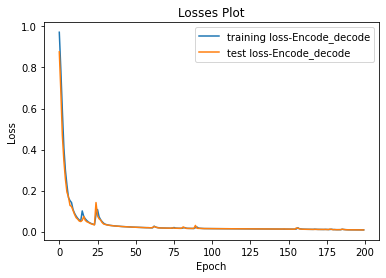

In [3]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
#perm_list=torch.load(dataset_dir+'/perm_list.pt')
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/bubble_EMD/Encode_state_dict.pt'
pathD='/root/data1/bubble_EMD/Decode_state_dict.pt'
pathED = '/root/data1/bubble_EMD/ED_state_dict.pt'
epochs = 200

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = get_EDstats(dataset)

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
torch.save(EDstats_list,dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]  #2
in_channels_edge = sample.edge_attr.shape[1]  #3
hidden_channels = 32    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=32
ae_dim=[300,128,64,32]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[2700,2000,1400]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
#model.load_state_dict(torch.load(pathED), strict=False)
train_hist, test_hist=train(epochs, model, perm_list,train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,pathED,pathD,pathE)
plot_dir='/root/data1/bubble_EMD/loss/'
save_DEplots(train_hist, test_hist,plot_dir)

cuda
cuda:0
8


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/200 [00:44<2:27:25, 44.45s/Epochs]

Epoch: 0000,	Train mse: 0.03789627,	Train_RMSE: 0.18043524,	Train_acc: 0.18026893,	Test mse: 0.01348684,	Time: 44.44731426s


Training:   2%|▏         | 3/200 [02:13<2:25:59, 44.46s/Epochs]

Epoch: 0002,	Train mse: 0.01448815,	Train_RMSE: 0.11925279,	Train_acc: 0.11930196,	Test mse: 0.01478556,	Time: 44.79496169s


Training:   2%|▎         | 5/200 [03:41<2:24:14, 44.38s/Epochs]

Epoch: 0004,	Train mse: 0.00959844,	Train_RMSE: 0.09787181,	Train_acc: 0.09787662,	Test mse: 0.00864238,	Time: 45.39447904s


Training:   4%|▎         | 7/200 [05:10<2:23:02, 44.47s/Epochs]

Epoch: 0006,	Train mse: 0.00836352,	Train_RMSE: 0.09144580,	Train_acc: 0.09144579,	Test mse: 0.00839268,	Time: 44.42085981s


Training:   4%|▍         | 9/200 [06:38<2:20:21, 44.09s/Epochs]

Epoch: 0008,	Train mse: 0.00807505,	Train_RMSE: 0.08985265,	Train_acc: 0.08985189,	Test mse: 0.00800673,	Time: 43.79949450s


Training:   6%|▌         | 11/200 [08:06<2:18:38, 44.01s/Epochs]

Epoch: 0010,	Train mse: 0.00797833,	Train_RMSE: 0.08931345,	Train_acc: 0.08931264,	Test mse: 0.00793308,	Time: 42.71037769s


Training:   6%|▋         | 13/200 [09:39<2:21:33, 45.42s/Epochs]

Epoch: 0012,	Train mse: 0.00791359,	Train_RMSE: 0.08895066,	Train_acc: 0.08894971,	Test mse: 0.00787842,	Time: 46.98596501s


Training:   8%|▊         | 15/200 [11:08<2:17:55, 44.73s/Epochs]

Epoch: 0014,	Train mse: 0.00786585,	Train_RMSE: 0.08868184,	Train_acc: 0.08868088,	Test mse: 0.00783267,	Time: 43.69189095s


Training:   8%|▊         | 17/200 [12:37<2:16:33, 44.77s/Epochs]

Epoch: 0016,	Train mse: 0.00782458,	Train_RMSE: 0.08844892,	Train_acc: 0.08844798,	Test mse: 0.00778962,	Time: 45.31643724s


Training:  10%|▉         | 19/200 [14:09<2:16:50, 45.36s/Epochs]

Epoch: 0018,	Train mse: 0.00778053,	Train_RMSE: 0.08819959,	Train_acc: 0.08819864,	Test mse: 0.00774445,	Time: 46.30715466s


Training:  10%|█         | 21/200 [15:39<2:15:16, 45.34s/Epochs]

Epoch: 0020,	Train mse: 0.00773617,	Train_RMSE: 0.08794786,	Train_acc: 0.08794692,	Test mse: 0.00770136,	Time: 45.89549589s


Training:  12%|█▏        | 23/200 [17:12<2:15:31, 45.94s/Epochs]

Epoch: 0022,	Train mse: 0.00769341,	Train_RMSE: 0.08770452,	Train_acc: 0.08770364,	Test mse: 0.00765983,	Time: 47.29850793s


Training:  12%|█▎        | 25/200 [18:41<2:11:47, 45.18s/Epochs]

Epoch: 0024,	Train mse: 0.00765097,	Train_RMSE: 0.08746239,	Train_acc: 0.08746152,	Test mse: 0.00761648,	Time: 44.70537496s


Training:  14%|█▎        | 27/200 [20:11<2:10:15, 45.18s/Epochs]

Epoch: 0026,	Train mse: 0.00760715,	Train_RMSE: 0.08721164,	Train_acc: 0.08721081,	Test mse: 0.00757051,	Time: 44.78803778s


Training:  14%|█▍        | 29/200 [21:40<2:07:33, 44.76s/Epochs]

Epoch: 0028,	Train mse: 0.00756398,	Train_RMSE: 0.08696389,	Train_acc: 0.08696308,	Test mse: 0.00752140,	Time: 44.53442550s


Training:  16%|█▌        | 31/200 [23:11<2:06:55, 45.06s/Epochs]

Epoch: 0030,	Train mse: 0.00751917,	Train_RMSE: 0.08670588,	Train_acc: 0.08670501,	Test mse: 0.00747367,	Time: 44.49616647s


Training:  16%|█▋        | 33/200 [24:42<2:05:53, 45.23s/Epochs]

Epoch: 0032,	Train mse: 0.00747260,	Train_RMSE: 0.08643702,	Train_acc: 0.08643616,	Test mse: 0.00742902,	Time: 45.39495254s


Training:  18%|█▊        | 35/200 [26:17<2:08:14, 46.64s/Epochs]

Epoch: 0034,	Train mse: 0.00742496,	Train_RMSE: 0.08616107,	Train_acc: 0.08616024,	Test mse: 0.00738291,	Time: 48.59754014s


Training:  18%|█▊        | 37/200 [27:49<2:05:57, 46.36s/Epochs]

Epoch: 0036,	Train mse: 0.00738054,	Train_RMSE: 0.08590292,	Train_acc: 0.08590207,	Test mse: 0.00733567,	Time: 47.50753498s


Training:  20%|█▉        | 39/200 [29:23<2:05:29, 46.77s/Epochs]

Epoch: 0038,	Train mse: 0.00733551,	Train_RMSE: 0.08564046,	Train_acc: 0.08563963,	Test mse: 0.00729224,	Time: 47.20447969s


Training:  20%|██        | 41/200 [30:57<2:03:43, 46.69s/Epochs]

Epoch: 0040,	Train mse: 0.00729014,	Train_RMSE: 0.08537520,	Train_acc: 0.08537439,	Test mse: 0.00724638,	Time: 45.99414229s


Training:  22%|██▏       | 43/200 [32:32<2:03:23, 47.16s/Epochs]

Epoch: 0042,	Train mse: 0.00724734,	Train_RMSE: 0.08512421,	Train_acc: 0.08512343,	Test mse: 0.00720305,	Time: 47.89764428s


Training:  22%|██▎       | 45/200 [34:04<2:00:25, 46.61s/Epochs]

Epoch: 0044,	Train mse: 0.00720381,	Train_RMSE: 0.08486821,	Train_acc: 0.08486743,	Test mse: 0.00716154,	Time: 45.51899505s


Training:  24%|██▎       | 47/200 [35:34<1:56:27, 45.67s/Epochs]

Epoch: 0046,	Train mse: 0.00716266,	Train_RMSE: 0.08462539,	Train_acc: 0.08462462,	Test mse: 0.00712067,	Time: 45.10503960s


Training:  24%|██▍       | 49/200 [37:06<1:55:58, 46.08s/Epochs]

Epoch: 0048,	Train mse: 0.00712061,	Train_RMSE: 0.08437664,	Train_acc: 0.08437589,	Test mse: 0.00707779,	Time: 47.57798815s


Training:  26%|██▌       | 51/200 [38:40<1:55:31, 46.52s/Epochs]

Epoch: 0050,	Train mse: 0.00707998,	Train_RMSE: 0.08413566,	Train_acc: 0.08413494,	Test mse: 0.00703763,	Time: 46.88491297s


Training:  26%|██▋       | 53/200 [40:15<1:55:21, 47.09s/Epochs]

Epoch: 0052,	Train mse: 0.00704034,	Train_RMSE: 0.08389972,	Train_acc: 0.08389901,	Test mse: 0.00699320,	Time: 48.21677113s


Training:  28%|██▊       | 55/200 [41:48<1:53:14, 46.86s/Epochs]

Epoch: 0054,	Train mse: 0.00699809,	Train_RMSE: 0.08364766,	Train_acc: 0.08364694,	Test mse: 0.00694888,	Time: 47.09838080s


Training:  28%|██▊       | 57/200 [43:19<1:49:49, 46.08s/Epochs]

Epoch: 0056,	Train mse: 0.00695675,	Train_RMSE: 0.08340016,	Train_acc: 0.08339944,	Test mse: 0.00690718,	Time: 44.28279614s


Training:  30%|██▉       | 59/200 [44:54<1:50:07, 46.86s/Epochs]

Epoch: 0058,	Train mse: 0.00691674,	Train_RMSE: 0.08315999,	Train_acc: 0.08315925,	Test mse: 0.00686676,	Time: 48.60281610s


Training:  30%|███       | 61/200 [46:32<1:51:14, 48.02s/Epochs]

Epoch: 0060,	Train mse: 0.00687581,	Train_RMSE: 0.08291355,	Train_acc: 0.08291283,	Test mse: 0.00682632,	Time: 50.69930434s


Training:  32%|███▏      | 63/200 [48:08<1:50:02, 48.20s/Epochs]

Epoch: 0062,	Train mse: 0.00683699,	Train_RMSE: 0.08267920,	Train_acc: 0.08267848,	Test mse: 0.00678541,	Time: 48.19547486s


Training:  32%|███▎      | 65/200 [49:37<1:44:07, 46.27s/Epochs]

Epoch: 0064,	Train mse: 0.00679864,	Train_RMSE: 0.08244697,	Train_acc: 0.08244625,	Test mse: 0.00674676,	Time: 45.00894737s


Training:  34%|███▎      | 67/200 [51:13<1:44:22, 47.08s/Epochs]

Epoch: 0066,	Train mse: 0.00676077,	Train_RMSE: 0.08221691,	Train_acc: 0.08221619,	Test mse: 0.00670789,	Time: 47.82007480s


Training:  34%|███▍      | 69/200 [52:48<1:43:25, 47.37s/Epochs]

Epoch: 0068,	Train mse: 0.00672321,	Train_RMSE: 0.08198821,	Train_acc: 0.08198749,	Test mse: 0.00666847,	Time: 47.40335631s


Training:  36%|███▌      | 71/200 [54:26<1:43:35, 48.18s/Epochs]

Epoch: 0070,	Train mse: 0.00668590,	Train_RMSE: 0.08176040,	Train_acc: 0.08175969,	Test mse: 0.00663118,	Time: 49.29139614s


Training:  36%|███▋      | 73/200 [55:57<1:38:59, 46.77s/Epochs]

Epoch: 0072,	Train mse: 0.00664939,	Train_RMSE: 0.08153683,	Train_acc: 0.08153611,	Test mse: 0.00659299,	Time: 45.90356565s


Training:  38%|███▊      | 75/200 [57:32<1:38:28, 47.27s/Epochs]

Epoch: 0074,	Train mse: 0.00661359,	Train_RMSE: 0.08131703,	Train_acc: 0.08131631,	Test mse: 0.00655560,	Time: 46.72396564s


Training:  38%|███▊      | 77/200 [59:00<1:33:28, 45.59s/Epochs]

Epoch: 0076,	Train mse: 0.00657607,	Train_RMSE: 0.08108608,	Train_acc: 0.08108538,	Test mse: 0.00651971,	Time: 43.90783095s


Training:  40%|███▉      | 79/200 [1:00:33<1:32:49, 46.03s/Epochs]

Epoch: 0078,	Train mse: 0.00654075,	Train_RMSE: 0.08086791,	Train_acc: 0.08086720,	Test mse: 0.00648254,	Time: 46.91247201s


Training:  40%|████      | 81/200 [1:02:08<1:32:56, 46.86s/Epochs]

Epoch: 0080,	Train mse: 0.00650627,	Train_RMSE: 0.08065450,	Train_acc: 0.08065380,	Test mse: 0.00644890,	Time: 47.68839407s


Training:  42%|████▏     | 83/200 [1:03:44<1:32:29, 47.43s/Epochs]

Epoch: 0082,	Train mse: 0.00647277,	Train_RMSE: 0.08044652,	Train_acc: 0.08044580,	Test mse: 0.00641477,	Time: 48.38744164s


Training:  42%|████▎     | 85/200 [1:05:18<1:30:15, 47.09s/Epochs]

Epoch: 0084,	Train mse: 0.00643993,	Train_RMSE: 0.08024198,	Train_acc: 0.08024120,	Test mse: 0.00637665,	Time: 47.00323486s


Training:  44%|████▎     | 87/200 [1:06:52<1:28:39, 47.08s/Epochs]

Epoch: 0086,	Train mse: 0.00640548,	Train_RMSE: 0.08002737,	Train_acc: 0.08002667,	Test mse: 0.00634154,	Time: 46.89628673s


Training:  44%|████▍     | 89/200 [1:08:26<1:27:17, 47.18s/Epochs]

Epoch: 0088,	Train mse: 0.00637239,	Train_RMSE: 0.07982026,	Train_acc: 0.07981952,	Test mse: 0.00630947,	Time: 47.87825370s


Training:  46%|████▌     | 91/200 [1:10:02<1:26:35, 47.67s/Epochs]

Epoch: 0090,	Train mse: 0.00634564,	Train_RMSE: 0.07965227,	Train_acc: 0.07965144,	Test mse: 0.00628264,	Time: 49.19625330s


Training:  46%|████▋     | 93/200 [1:11:36<1:24:29, 47.38s/Epochs]

Epoch: 0092,	Train mse: 0.00631938,	Train_RMSE: 0.07948722,	Train_acc: 0.07948641,	Test mse: 0.00628142,	Time: 46.68162060s


Training:  48%|████▊     | 95/200 [1:13:13<1:23:51, 47.92s/Epochs]

Epoch: 0094,	Train mse: 0.00631197,	Train_RMSE: 0.07944263,	Train_acc: 0.07944235,	Test mse: 0.00622775,	Time: 48.88131475s


Training:  48%|████▊     | 97/200 [1:14:45<1:20:04, 46.64s/Epochs]

Epoch: 0096,	Train mse: 0.00627509,	Train_RMSE: 0.07920718,	Train_acc: 0.07920599,	Test mse: 0.00621547,	Time: 43.79930449s


Training:  50%|████▉     | 99/200 [1:16:16<1:17:25, 45.99s/Epochs]

Epoch: 0098,	Train mse: 0.00635802,	Train_RMSE: 0.07972706,	Train_acc: 0.07972532,	Test mse: 0.00627446,	Time: 44.29397154s


Training:  50%|█████     | 101/200 [1:17:51<1:17:16, 46.83s/Epochs]

Epoch: 0100,	Train mse: 0.00624529,	Train_RMSE: 0.07901679,	Train_acc: 0.07901504,	Test mse: 0.00621760,	Time: 47.31072831s


Training:  52%|█████▏    | 103/200 [1:19:26<1:16:03, 47.05s/Epochs]

Epoch: 0102,	Train mse: 0.00618868,	Train_RMSE: 0.07866256,	Train_acc: 0.07866210,	Test mse: 0.00614626,	Time: 47.10401177s


Training:  52%|█████▎    | 105/200 [1:21:00<1:14:40, 47.17s/Epochs]

Epoch: 0104,	Train mse: 0.00615354,	Train_RMSE: 0.07843887,	Train_acc: 0.07843837,	Test mse: 0.00610547,	Time: 47.40143394s


Training:  54%|█████▎    | 107/200 [1:22:34<1:12:39, 46.88s/Epochs]

Epoch: 0106,	Train mse: 0.00615075,	Train_RMSE: 0.07842187,	Train_acc: 0.07842162,	Test mse: 0.00605265,	Time: 46.12490964s


Training:  55%|█████▍    | 109/200 [1:24:09<1:11:35, 47.20s/Epochs]

Epoch: 0108,	Train mse: 0.00614103,	Train_RMSE: 0.07836038,	Train_acc: 0.07836101,	Test mse: 0.00600805,	Time: 47.59841537s


Training:  56%|█████▌    | 111/200 [1:25:44<1:10:20, 47.42s/Epochs]

Epoch: 0110,	Train mse: 0.00610648,	Train_RMSE: 0.07814023,	Train_acc: 0.07814077,	Test mse: 0.00606140,	Time: 47.31082273s


Training:  56%|█████▋    | 113/200 [1:27:18<1:08:25, 47.19s/Epochs]

Epoch: 0112,	Train mse: 0.00606291,	Train_RMSE: 0.07786015,	Train_acc: 0.07786010,	Test mse: 0.00601743,	Time: 47.30250669s


Training:  57%|█████▊    | 115/200 [1:28:56<1:08:08, 48.10s/Epochs]

Epoch: 0114,	Train mse: 0.00602198,	Train_RMSE: 0.07759596,	Train_acc: 0.07759576,	Test mse: 0.00600100,	Time: 49.10315633s


Training:  58%|█████▊    | 117/200 [1:30:28<1:05:04, 47.04s/Epochs]

Epoch: 0116,	Train mse: 0.00603297,	Train_RMSE: 0.07766773,	Train_acc: 0.07766765,	Test mse: 0.00610686,	Time: 46.40136361s


Training:  60%|█████▉    | 119/200 [1:32:02<1:03:40, 47.17s/Epochs]

Epoch: 0118,	Train mse: 0.00604006,	Train_RMSE: 0.07771207,	Train_acc: 0.07771233,	Test mse: 0.00603065,	Time: 48.19056010s


Training:  60%|██████    | 121/200 [1:33:37<1:02:13, 47.25s/Epochs]

Epoch: 0120,	Train mse: 0.00597485,	Train_RMSE: 0.07729303,	Train_acc: 0.07729340,	Test mse: 0.00587755,	Time: 46.78596163s


Training:  62%|██████▏   | 123/200 [1:35:08<59:31, 46.38s/Epochs]  

Epoch: 0122,	Train mse: 0.00588187,	Train_RMSE: 0.07668639,	Train_acc: 0.07668564,	Test mse: 0.00580805,	Time: 45.20785427s


Training:  62%|██████▎   | 125/200 [1:36:38<57:17, 45.83s/Epochs]

Epoch: 0124,	Train mse: 0.00588118,	Train_RMSE: 0.07668320,	Train_acc: 0.07668287,	Test mse: 0.00580069,	Time: 45.59440970s


Training:  64%|██████▎   | 127/200 [1:38:11<55:59, 46.03s/Epochs]

Epoch: 0126,	Train mse: 0.00606391,	Train_RMSE: 0.07784475,	Train_acc: 0.07784062,	Test mse: 0.00657813,	Time: 46.62705803s


Training:  64%|██████▍   | 129/200 [1:39:43<54:45, 46.27s/Epochs]

Epoch: 0128,	Train mse: 0.00603600,	Train_RMSE: 0.07768816,	Train_acc: 0.07768980,	Test mse: 0.00611466,	Time: 47.03337264s


Training:  66%|██████▌   | 131/200 [1:41:11<51:50, 45.07s/Epochs]

Epoch: 0130,	Train mse: 0.00591361,	Train_RMSE: 0.07688825,	Train_acc: 0.07688770,	Test mse: 0.00576862,	Time: 43.51465511s


Training:  66%|██████▋   | 133/200 [1:42:40<50:09, 44.92s/Epochs]

Epoch: 0132,	Train mse: 0.00582100,	Train_RMSE: 0.07628599,	Train_acc: 0.07628469,	Test mse: 0.00567870,	Time: 46.28287935s


Training:  68%|██████▊   | 135/200 [1:44:15<50:12, 46.35s/Epochs]

Epoch: 0134,	Train mse: 0.00575862,	Train_RMSE: 0.07587927,	Train_acc: 0.07587856,	Test mse: 0.00574250,	Time: 49.20699644s


Training:  68%|██████▊   | 137/200 [1:45:40<46:20, 44.14s/Epochs]

Epoch: 0136,	Train mse: 0.00578146,	Train_RMSE: 0.07603068,	Train_acc: 0.07603077,	Test mse: 0.00577646,	Time: 40.00142932s


Training:  70%|██████▉   | 139/200 [1:46:45<38:47, 38.16s/Epochs]

Epoch: 0138,	Train mse: 0.00574234,	Train_RMSE: 0.07577364,	Train_acc: 0.07577377,	Test mse: 0.00570258,	Time: 32.30059028s
Epoch   139: reducing learning rate of group 0 to 5.0000e-05.


Training:  70%|███████   | 141/200 [1:47:51<34:52, 35.46s/Epochs]

Epoch: 0140,	Train mse: 0.00568922,	Train_RMSE: 0.07541947,	Train_acc: 0.07541849,	Test mse: 0.00562839,	Time: 32.68789411s


Training:  72%|███████▏  | 143/200 [1:48:55<31:53, 33.56s/Epochs]

Epoch: 0142,	Train mse: 0.00565724,	Train_RMSE: 0.07520740,	Train_acc: 0.07520656,	Test mse: 0.00558601,	Time: 30.99859571s


Training:  72%|███████▎  | 145/200 [1:49:58<29:59, 32.71s/Epochs]

Epoch: 0144,	Train mse: 0.00564322,	Train_RMSE: 0.07511413,	Train_acc: 0.07511331,	Test mse: 0.00556972,	Time: 32.08767700s


Training:  74%|███████▎  | 147/200 [1:51:04<28:57, 32.78s/Epochs]

Epoch: 0146,	Train mse: 0.00562935,	Train_RMSE: 0.07502174,	Train_acc: 0.07502093,	Test mse: 0.00555386,	Time: 32.39531827s


Training:  74%|███████▍  | 149/200 [1:52:08<27:29, 32.35s/Epochs]

Epoch: 0148,	Train mse: 0.00561724,	Train_RMSE: 0.07494097,	Train_acc: 0.07494017,	Test mse: 0.00554144,	Time: 32.01093841s


Training:  76%|███████▌  | 151/200 [1:53:13<26:23, 32.32s/Epochs]

Epoch: 0150,	Train mse: 0.00560518,	Train_RMSE: 0.07486048,	Train_acc: 0.07485967,	Test mse: 0.00552969,	Time: 32.00081825s


Training:  76%|███████▋  | 153/200 [1:54:18<25:22, 32.39s/Epochs]

Epoch: 0152,	Train mse: 0.00559299,	Train_RMSE: 0.07477904,	Train_acc: 0.07477823,	Test mse: 0.00551751,	Time: 32.58177018s


Training:  78%|███████▊  | 155/200 [1:55:21<24:05, 32.13s/Epochs]

Epoch: 0154,	Train mse: 0.00558060,	Train_RMSE: 0.07469619,	Train_acc: 0.07469539,	Test mse: 0.00550494,	Time: 31.78609371s


Training:  78%|███████▊  | 157/200 [1:56:25<22:55, 31.99s/Epochs]

Epoch: 0156,	Train mse: 0.00556986,	Train_RMSE: 0.07462430,	Train_acc: 0.07462350,	Test mse: 0.00549381,	Time: 32.09369230s


Training:  80%|███████▉  | 159/200 [1:57:29<21:54, 32.06s/Epochs]

Epoch: 0158,	Train mse: 0.00555684,	Train_RMSE: 0.07453693,	Train_acc: 0.07453613,	Test mse: 0.00548087,	Time: 31.59862185s


Training:  80%|████████  | 161/200 [1:58:32<20:38, 31.75s/Epochs]

Epoch: 0160,	Train mse: 0.00554533,	Train_RMSE: 0.07445971,	Train_acc: 0.07445892,	Test mse: 0.00546944,	Time: 31.40555930s


Training:  82%|████████▏ | 163/200 [1:59:36<19:32, 31.70s/Epochs]

Epoch: 0162,	Train mse: 0.00553372,	Train_RMSE: 0.07438168,	Train_acc: 0.07438089,	Test mse: 0.00545728,	Time: 31.70032120s


Training:  82%|████████▎ | 165/200 [2:00:38<18:22, 31.49s/Epochs]

Epoch: 0164,	Train mse: 0.00552262,	Train_RMSE: 0.07430709,	Train_acc: 0.07430628,	Test mse: 0.00544523,	Time: 31.47345400s


Training:  84%|████████▎ | 167/200 [2:01:43<17:33, 31.92s/Epochs]

Epoch: 0166,	Train mse: 0.00550958,	Train_RMSE: 0.07421929,	Train_acc: 0.07421848,	Test mse: 0.00543229,	Time: 32.41135502s


Training:  84%|████████▍ | 169/200 [2:02:48<16:44, 32.40s/Epochs]

Epoch: 0168,	Train mse: 0.00549778,	Train_RMSE: 0.07413973,	Train_acc: 0.07413892,	Test mse: 0.00542146,	Time: 32.89945149s


Training:  86%|████████▌ | 171/200 [2:03:55<15:49, 32.74s/Epochs]

Epoch: 0170,	Train mse: 0.00548552,	Train_RMSE: 0.07405704,	Train_acc: 0.07405624,	Test mse: 0.00540749,	Time: 33.19041944s


Training:  86%|████████▋ | 173/200 [2:05:00<14:40, 32.61s/Epochs]

Epoch: 0172,	Train mse: 0.00547431,	Train_RMSE: 0.07398135,	Train_acc: 0.07398054,	Test mse: 0.00539529,	Time: 32.12288117s


Training:  88%|████████▊ | 175/200 [2:06:06<13:42, 32.88s/Epochs]

Epoch: 0174,	Train mse: 0.00546231,	Train_RMSE: 0.07390020,	Train_acc: 0.07389941,	Test mse: 0.00538564,	Time: 33.40420508s


Training:  88%|████████▊ | 177/200 [2:07:11<12:32, 32.70s/Epochs]

Epoch: 0176,	Train mse: 0.00544917,	Train_RMSE: 0.07381120,	Train_acc: 0.07381041,	Test mse: 0.00537662,	Time: 32.40304399s


Training:  90%|████████▉ | 179/200 [2:08:18<11:34, 33.09s/Epochs]

Epoch: 0178,	Train mse: 0.00543743,	Train_RMSE: 0.07373166,	Train_acc: 0.07373088,	Test mse: 0.00536062,	Time: 33.99122643s


Training:  90%|█████████ | 181/200 [2:09:23<10:24, 32.89s/Epochs]

Epoch: 0180,	Train mse: 0.00542399,	Train_RMSE: 0.07364048,	Train_acc: 0.07363968,	Test mse: 0.00534707,	Time: 32.69439530s


Training:  92%|█████████▏| 183/200 [2:10:28<09:15, 32.67s/Epochs]

Epoch: 0182,	Train mse: 0.00541227,	Train_RMSE: 0.07356088,	Train_acc: 0.07356010,	Test mse: 0.00533387,	Time: 32.41396236s


Training:  92%|█████████▎| 185/200 [2:11:33<08:08, 32.57s/Epochs]

Epoch: 0184,	Train mse: 0.00539894,	Train_RMSE: 0.07347020,	Train_acc: 0.07346940,	Test mse: 0.00532064,	Time: 31.98319292s


Training:  94%|█████████▎| 187/200 [2:12:38<07:01, 32.39s/Epochs]

Epoch: 0186,	Train mse: 0.00538823,	Train_RMSE: 0.07339722,	Train_acc: 0.07339641,	Test mse: 0.00531103,	Time: 32.09550357s


Training:  94%|█████████▍| 189/200 [2:13:44<06:00, 32.75s/Epochs]

Epoch: 0188,	Train mse: 0.00537523,	Train_RMSE: 0.07330874,	Train_acc: 0.07330797,	Test mse: 0.00529695,	Time: 33.29892492s


Training:  96%|█████████▌| 191/200 [2:14:49<04:54, 32.72s/Epochs]

Epoch: 0190,	Train mse: 0.00536208,	Train_RMSE: 0.07321895,	Train_acc: 0.07321817,	Test mse: 0.00528562,	Time: 32.81231260s


Training:  96%|█████████▋| 193/200 [2:15:54<03:47, 32.54s/Epochs]

Epoch: 0192,	Train mse: 0.00535058,	Train_RMSE: 0.07314040,	Train_acc: 0.07313961,	Test mse: 0.00527180,	Time: 32.29812598s


Training:  98%|█████████▊| 195/200 [2:16:59<02:41, 32.40s/Epochs]

Epoch: 0194,	Train mse: 0.00533788,	Train_RMSE: 0.07305351,	Train_acc: 0.07305273,	Test mse: 0.00526069,	Time: 31.80998278s


Training:  98%|█████████▊| 197/200 [2:18:01<01:35, 31.92s/Epochs]

Epoch: 0196,	Train mse: 0.00532763,	Train_RMSE: 0.07298331,	Train_acc: 0.07298254,	Test mse: 0.00525158,	Time: 31.71164632s


Training: 100%|█████████▉| 199/200 [2:19:05<00:31, 31.91s/Epochs]

Epoch: 0198,	Train mse: 0.00531552,	Train_RMSE: 0.07290028,	Train_acc: 0.07289948,	Test mse: 0.00523543,	Time: 32.21255541s


Training: 100%|██████████| 200/200 [2:19:38<00:00, 41.89s/Epochs]


Model.state_dict:
node_encode.0.weight 	 torch.Size([32, 2])
node_encode.0.bias 	 torch.Size([32])
node_encode.1.weight 	 torch.Size([32, 32])
node_encode.1.bias 	 torch.Size([32])
node_encode.2.weight 	 torch.Size([32, 32])
node_encode.2.bias 	 torch.Size([32])
node_encode.3.weight 	 torch.Size([32, 32])
node_encode.3.bias 	 torch.Size([32])
node_encode_norm.weight 	 torch.Size([32])
node_encode_norm.bias 	 torch.Size([32])
edge_encode.0.weight 	 torch.Size([32, 3])
edge_encode.0.bias 	 torch.Size([32])
edge_encode.1.weight 	 torch.Size([32, 32])
edge_encode.1.bias 	 torch.Size([32])
edge_encode.2.weight 	 torch.Size([32, 32])
edge_encode.2.bias 	 torch.Size([32])
edge_encode.3.weight 	 torch.Size([32, 32])
edge_encode.3.bias 	 torch.Size([32])
edge_encode_norm.weight 	 torch.Size([32])
edge_encode_norm.bias 	 torch.Size([32])
edge_down_mps.0.0.0.weight 	 torch.Size([32, 96])
edge_down_mps.0.0.0.bias 	 torch.Size([32])
edge_down_mps.0.0.1.weight 	 torch.Size([32, 32])
edge_down_mps.0.

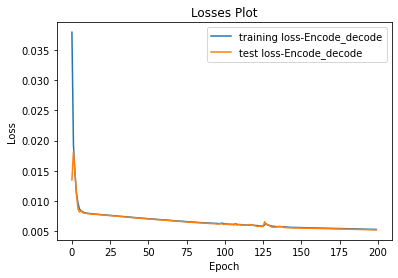

In [3]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
#perm_list=torch.load(dataset_dir+'/perm_list.pt')
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/bubble_EMD/Encode_state_dict.pt'
pathD='/root/data1/bubble_EMD/Decode_state_dict.pt'
pathED = '/root/data1/bubble_EMD/ED_state_dict.pt'
epochs = 200

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
#EDstats_list = get_EDstats(dataset)

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] =torch.load(dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]  #2
in_channels_edge = sample.edge_attr.shape[1]  #3
hidden_channels = 32    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=32
ae_dim=[300,128,64,32]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[2700,2000,1400]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')

model.to(device)
model.load_state_dict(torch.load(pathED), strict=False)
train_hist, test_hist=train(epochs, model, perm_list,train_loader, valid_loader,per_t,batch_size,
                            EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,pathED,pathD,pathE)
plot_dir='/root/data1/bubble_EMD/loss/'
save_DEplots(train_hist, test_hist,plot_dir)

In [4]:
model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
model.to(device)
model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load(file_path)
print(len(dataset))   #6
n=int(len(dataset)/number_trajectories)
nn=int(n*batch_size)
print(n,nn)#6,150

#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)

file_path_ed= dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input))  #150
print(dataset_input[0])    

for i in range(number_trajectories):
  dataset_=dataset[i*n:(i+1)*n]
  num_=int(dataset_[0].x.shape[0]/(per_t*batch_size))
  loader_ = DataLoader(dataset_,  shuffle=False)
  pred_=torch.tensor([[0,0]]).type(torch.float).to(device)
  #pred_=torch.tensor([[0]]).type(torch.float).to(device)
  per_t=1
  batch_size=25    #改
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  with torch.no_grad():
    for step, data in enumerate(loader_):
      data=data.to(device)
      
      out, _ = model(data, per_t ,perm_list[0], batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
      pred_=torch.vstack((pred_,out))
  pred_=pred_[1:,:]
  print(pred_.shape)   #150*3718,2
  pred_=pred_*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
  dataset_input_=dataset_input[i*nn:(i+1)*nn]

  pred_=pred_.to('cpu')

  viz_data_loader_ = copy.deepcopy(dataset_input_)
  


  for j in range(int(pred_.shape[0]/num_)):
    viz_data_loader_[j].x=pred_[j*num_:(j+1)*num_,:]
    
  torch.save(viz_data_loader_,dataset_dir+'/encode_decode_output_'+str(i)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#200个data


8
8 200
200
Data(x=[3351, 2], edge_index=[2, 19634], edge_attr=[19634, 3], cells=[6467, 3], mesh_pos=[3351, 2])


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


torch.Size([670200, 2])


查看还原效果

复制到文件夹查看还原效果

In [5]:
for i in range(number_trajectories):
    data=torch.load(dataset_dir+'/encode_decode_output_'+str(i)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    print(len(data))
    print(data[0])
    num=200
    originalFolder='/root/data1/water_slice_'+str(i)
    destinationFolder='/root/data1/bubble_dataset_EDoutput_'+str(i)
    fileName="/slice_"
    transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName)

200
Data(x=[3351, 2], edge_index=[2, 19634], edge_attr=[19634, 3], cells=[6467, 3], mesh_pos=[3351, 2])
start to create the destination folder
start to store data as a new variable
transform succeed


In [3]:
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
#perm_list=torch.load(dataset_dir+'/perm_list.pt')
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/bubble_EMD/Encode_state_dict.pt'
pathD='/root/data1/bubble_EMD/Decode_state_dict.pt'
pathED = '/root/data1/bubble_EMD/ED_state_dict.pt'
epochs = 400

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
EDstats_list = get_EDstats(dataset)

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
torch.save(EDstats_list,dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=11        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]  #2
in_channels_edge = sample.edge_attr.shape[1]  #3
hidden_channels = 25    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=32
ae_dim=[300,128,64,32]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[3100,2600,2100]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

cuda
cuda:0
12


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


生成低维数据

In [6]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)


dataset_dir = '/root/data1/bubble_EMD'
path='/root/data1/water_slice_'

get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_M = torch.load(file_path)
print(len(dataset_M))   #长度为150  

/root/data1/water_slice_0
501


2024-10-21 21:39:51.611756: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 21:39:51.619701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7894 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:9c:00.0, compute capability: 8.9


Done collecting data!
Done saving data!
Output Location:  /root/data1/bubble_EMD/meshgraphnets_miniset12001traj50200ts_vis.pt
1


In [7]:

M_encode=GNN_topk_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
M_encode.to(device)
M_encode.load_state_dict(torch.load(pathE), strict=False)
with torch.no_grad():
  for i in range(len(dataset_M)):
    dataset_M[i]=dataset_M[i].to(device)
    data_list,batches , xs, positions, edge_attrs, edge_indices, edge_masks= M_encode(dataset_M[i], per_t , perm_list[0],
                                                                                            batch_size,EDmean_vec_x,EDstd_vec_x,
                                                                                            EDmean_vec_edge,EDstd_vec_edge,
                                                                                            batch=None, return_mask=False)  
    torch.save(data_list,dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)+'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    torch.save(batches,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
    torch.save(xs,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
    torch.save( positions,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
    torch.save( edge_attrs,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
    torch.save( edge_indices,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
    torch.save( edge_masks,dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
    
    print(len(data_list))
    print(data_list[0],data_list[1],data_list[2],data_list[3],data_list[4],data_list[5])

200
Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32])


In [8]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)
a=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
edge_num=a[0].edge_attr.shape[0]
print(edge_num)    #3264

3264


在低维上进行时序预测

训练预测边属性模型

In [9]:
data_1=[]
data_label_1=[]

for i in range(number_trajectories):
    per_t=1
    dataset_encode=dataset_encode=torch.load(dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    per_t=11
    for j in range(len(dataset_encode)-per_t+1):
        for k in range(per_t):
            if k <(per_t-1):
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_1.append(E_data)
            else:
                E_data  = copy.deepcopy(dataset_encode[j+k])
                E_data=E_data.to('cpu')
                data_label_1.append(E_data)
                       
print(len(data_1))      #140*10
print(len(data_label_1))   #140

data_=data_1
data_label=data_label_1

'''data_2=[]
data_label_2=[]

data_3=[]
data_label_3=[]

for i in range(len(dataset_encode)-per_t+1):
    if i in r_index:
        for j in range(per_t-1):
            E_data  = copy.deepcopy(data_1[i*(per_t-1)+j])
            
            data_2.append(E_data)
        E_data  = copy.deepcopy(data_label_1[i])
        data_label_2.append(E_data)
    else:
        for j in range(per_t-1):
            E_data  = copy.deepcopy(data_1[i*(per_t-1)+j])
            
            data_3.append(E_data)
        E_data  = copy.deepcopy(data_label_1[i])
        data_label_3.append(E_data)

print(len(data_2))      #40*10
print(len(data_label_2))   #40

print(len(data_3))      #100*10
print(len(data_label_3))   #100
    



data_=data_3+data_2
data_label=data_label_3+data_label_2'''



all=data_+data_label



data_stats_list = get_EDstats(all)

torch.save(data_stats_list,dataset_dir+'/data_stats_list.pt')



1900
190


In [10]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 2,
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 36,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':32,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 2500,#5000
         'attr_epochs':8000,#8000
         'train_size':140, #45
         'test_size': 50, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/bubble_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/bubble_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         'attr_train_size':270,
         'attr_batchsize':10,
        'n_graph_encode':[500,150,80,10],
        'pool_num':[2700,2000,1400]},
]:

        args = objectview(args)
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy
torch.cuda.manual_seed_all(5)   #GPU

cuda


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 1/2500 [00:05<3:51:56,  5.57s/Epochs]

train loss 1.021442 test loss 1.303388


Training:   4%|▍         | 101/2500 [05:19<2:36:43,  3.92s/Epochs]

train loss 0.050373 test loss 0.049799


Training:   8%|▊         | 201/2500 [10:27<2:15:04,  3.53s/Epochs]

train loss 0.023556 test loss 0.020226


Training:  12%|█▏        | 301/2500 [15:50<2:25:17,  3.96s/Epochs]

train loss 0.02317 test loss 0.015876


Training:  16%|█▌        | 401/2500 [21:17<2:16:51,  3.91s/Epochs]

train loss 0.017891 test loss 0.014222


Training:  20%|██        | 501/2500 [26:39<2:12:11,  3.97s/Epochs]

train loss 0.016654 test loss 0.01372


Training:  24%|██▍       | 601/2500 [32:03<2:00:46,  3.82s/Epochs]

train loss 0.016549 test loss 0.015328


Training:  28%|██▊       | 701/2500 [39:11<2:13:45,  4.46s/Epochs]

train loss 0.013616 test loss 0.011659


Training:  32%|███▏      | 801/2500 [47:04<2:34:57,  5.47s/Epochs]

train loss 0.01631 test loss 0.011755


Training:  36%|███▌      | 901/2500 [56:48<2:46:53,  6.26s/Epochs]

train loss 0.012992 test loss 0.011698


Training:  38%|███▊      | 946/2500 [1:01:42<3:38:16,  8.43s/Epochs]

Epoch   946: reducing learning rate of group 0 to 5.0000e-05.


Training:  40%|████      | 1001/2500 [1:11:05<3:30:18,  8.42s/Epochs]

train loss 0.013299 test loss 0.010653


Training:  44%|████▍     | 1101/2500 [1:24:03<3:51:57,  9.95s/Epochs]

train loss 0.011803 test loss 0.010663


Training:  47%|████▋     | 1167/2500 [1:33:06<2:57:12,  7.98s/Epochs]

Epoch  1167: reducing learning rate of group 0 to 2.5000e-05.


Training:  48%|████▊     | 1201/2500 [1:37:57<3:15:36,  9.03s/Epochs]

train loss 0.011013 test loss 0.010212


Training:  52%|█████▏    | 1301/2500 [1:49:42<2:11:43,  6.59s/Epochs]

train loss 0.010071 test loss 0.009386


Training:  56%|█████▌    | 1401/2500 [2:01:44<2:07:55,  6.98s/Epochs]

train loss 0.010788 test loss 0.009543


Training:  58%|█████▊    | 1456/2500 [2:08:10<2:01:00,  6.95s/Epochs]

Epoch  1456: reducing learning rate of group 0 to 1.2500e-05.


Training:  60%|██████    | 1501/2500 [2:13:41<2:07:40,  7.67s/Epochs]

train loss 0.01018 test loss 0.009245


Training:  64%|██████▍   | 1601/2500 [2:26:16<1:58:14,  7.89s/Epochs]

train loss 0.01012 test loss 0.009248


Training:  68%|██████▊   | 1701/2500 [2:39:45<2:01:10,  9.10s/Epochs]

train loss 0.009689 test loss 0.009344


Training:  71%|███████   | 1775/2500 [2:51:37<1:41:40,  8.42s/Epochs]

Epoch  1775: reducing learning rate of group 0 to 6.2500e-06.


Training:  72%|███████▏  | 1801/2500 [2:55:57<2:21:16, 12.13s/Epochs]

train loss 0.009006 test loss 0.008854


Training:  76%|███████▌  | 1901/2500 [3:12:07<1:25:12,  8.53s/Epochs]

train loss 0.009149 test loss 0.008878


Training:  76%|███████▌  | 1904/2500 [3:12:43<1:49:29, 11.02s/Epochs]

Epoch  1904: reducing learning rate of group 0 to 3.1250e-06.


Training:  80%|████████  | 2001/2500 [3:28:58<1:22:46,  9.95s/Epochs]

train loss 0.009469 test loss 0.008797


Training:  80%|████████  | 2005/2500 [3:29:45<1:37:00, 11.76s/Epochs]

Epoch  2005: reducing learning rate of group 0 to 1.5625e-06.


Training:  84%|████████▍ | 2101/2500 [3:46:31<1:27:20, 13.13s/Epochs]

train loss 0.009981 test loss 0.008878


Training:  84%|████████▍ | 2106/2500 [3:47:18<1:01:15,  9.33s/Epochs]

Epoch  2106: reducing learning rate of group 0 to 1.0000e-06.


Training:  88%|████████▊ | 2201/2500 [4:04:17<58:42, 11.78s/Epochs]  

train loss 0.009794 test loss 0.008967


Training:  92%|█████████▏| 2301/2500 [4:21:56<33:41, 10.16s/Epochs]  

train loss 0.009545 test loss 0.008926


Training:  96%|█████████▌| 2401/2500 [4:39:53<17:43, 10.75s/Epochs]

train loss 0.009514 test loss 0.008809


Training: 100%|██████████| 2500/2500 [4:54:18<00:00,  7.06s/Epochs]

Min test set loss: 0.008644351735711098
Minimum loss: 0.008534951567915934


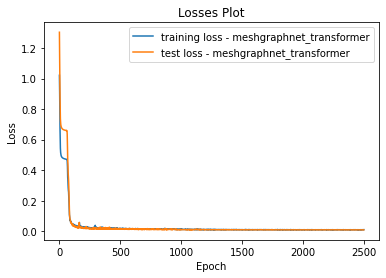

In [11]:
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)
#data_=data_[:1450]
#data_label=data_label[:290]
test_losses, losses, best_model,best_test_loss =gmesh_transformer_train(data_,data_label, device,data_stats_list, args,edge_num)
print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))

save_plots(args, losses, test_losses)

In [12]:
per_t=1     #在编码和解码的时候每三个时刻个用的点是一样的
batch_size = int(number_ts/per_t)
data_encode=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_encode))
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)

200
Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32])


In [12]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 2,
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 36,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':32,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 2500,#5000
         'attr_epochs':8000,#8000
         'train_size':140, #45
         'test_size': 50, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/bubble_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/bubble_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         'attr_train_size':270,
         'attr_batchsize':10,
        'n_graph_encode':[500,150,80,10],
        'pool_num':[2700,2000,1400]},
]:
        args = objectview(args)
    
model_name='g_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = MeshGraphNet_transformer(args,edge_num).to(device)
node_model.load_state_dict(torch.load('/root/data1/bubble_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))

EDstats_list=torch.load(dataset_dir+'/EDstats_list.pt')
data_stats_list=torch.load(dataset_dir+'/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)=(mean_vec_x.to(device),std_vec_x.to(device),
                                                   mean_vec_edge.to(device),std_vec_edge.to(device))

In [9]:
def predict_sequences_multiple(model, data, a, predict_num,seq_len):

        print('[Model] Predicting Sequences Multiple...')
        a=a.to(device)
        code_index=a.edge_index
        for i in range(predict_num):
          list_p = data[:] if i == 0 else data[i:]
          data_loader=DataLoader(list_p, batch_size=seq_len, shuffle=False) 
          for i,batch in enumerate(data_loader):
              batch=batch.to(device)
              code_x,code_edge_attr = gmesh_transformer_pred(batch,a,model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
          
          new_data=Data(x=code_x, edge_index=code_index, edge_attr=code_edge_attr)
          data.append(new_data)

        return data

In [15]:
predict_num=190
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60

[Model] Predicting Sequences Multiple...


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


200


In [16]:
i=0
batches=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')


perm_list=torch.load(dataset_dir+'/perm_list_150.pt')




decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

pred_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_x.append(x)

              
print(len(pred_x))

200


In [10]:
def ROM_transform_vector(data, satart_number_ts,number_ts, originalFolder, destinationFolder, fileName):

    folder = os.path.exists(destinationFolder)

    if not folder: 
        print('start to create the destination folder')   
        os.makedirs(destinationFolder)       
        copyFiles(originalFolder,destinationFolder) 

    print('start to store data as a new variable')
    
    for i in range(number_ts):
        f_filename = destinationFolder + fileName + str(i+satart_number_ts)+ ".vtk"
        reader=vtk.vtkPolyDataReader()
        reader.SetFileName(f_filename)  # SetFileName设置要读取的vtk文件
        reader.ReadAllScalarsOn()
        reader.ReadAllVectorsOn()
        reader.ReadAllTensorsOn()
        reader.Update()

        vtkdata=reader.GetOutput()  # GetOutput获取文件的数据
        num_points=vtkdata.GetNumberOfPoints() 
        point_data =vtkdata.GetPointData()
        a=data[i]
        a=a.to('cpu')
        a=a.numpy()
    
        velocity_array = point_data.GetArray('U.water')
        #print(velocity_array.GetTuple(0)[0:2])
        for j in range(num_points):
            original_velocity = list(velocity_array.GetTuple(j))
            original_velocity[0:2]=tuple(a[j])
            velocity_array.SetTuple(j, original_velocity)

        writer = vtk.vtkGenericDataObjectWriter()
        writer.SetFileName(f_filename)
        writer.SetInputData(vtkdata)
        writer.Write()
       
    print('transform succeed')	

In [18]:
for i in range(number_trajectories):
    satart_number_ts=50
    ts=len(pred_x)
    originalFolder='/root/data1/water_slice_'+str(i)
    destinationFolder='/root/data1/ROM_bubble_dataset_EDoutput_'+str(predict_num)+str(i)
    fileName="/slice_"
    ROM_transform_vector(pred_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [19]:
def pcc_of_two(ori_data, rom_data):

    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            pcc_x = pearson_value(y_u, y_0_u)
            pcc_y = pearson_value(y_v, y_0_v)
            plt.figure(1)
            plt.plot(pcc_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(pcc_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            pcc = pearson_value(ori_data, rom_data)
            # print(pcc.shape)
            plt.figure(1)
            # x = np.linspace(0,pcc.shape[0], num = pcc.shape[0])
            plt.plot(pcc)
            plt.ylim((0.85, 1))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            plt.show()
    else:
        print('the dimension of these two series are not equal. Please check them.')

200
(200, 6702) (200, 6702)


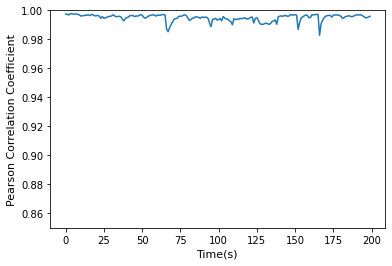

In [20]:
ED_out = pred_x   #60
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:200]

ts=200

for i in range(ts):
    
    uvw=ED_out[i].reshape(1,ED_out[i].shape[0],ED_out[i].shape[1]).to('cpu')
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_ = np.hstack((outputs[:,:,0],outputs[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_.shape,input_.shape)

pcc_of_two(input_, output_)

In [27]:
def mse(ori_data, rom_data):

    rmse_value = []
    acc=torch.nn.MSELoss(reduction='sum')
    acc1=torch.nn.MSELoss('mean')
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            #value = mean_squared_error(ori_data[i], rom_data[i])
            ori=torch.Tensor(ori_data[i])
            #print(ori.shape)
            rom=torch.Tensor(rom_data[i])
            #value =math.sqrt(acc(ori, rom))
            #print()
            #print((acc(ori, rom)))
            #print(math.sqrt((acc(ori, rom))))
            #print(acc1(ori, rom))
            #print(math.sqrt((acc1(ori, rom))))
            #k=(torch.norm(ori, p=1))/len(ori)
            #print(k)

            #value=acc1(ori,rom)
            value =math.sqrt((acc1(ori, rom)))
            #value =math.sqrt((acc1(ori, rom)))/k
            #value =math.sqrt((acc(ori, rom)))/(torch.norm(ori, p=1))
            #value =(acc(ori, rom)/torch.pow((torch.norm(ori, p=2)),2))
            #value =math.sqrt(acc(ori, rom)/(torch.pow((torch.norm(ori, p=2)),2)))
            #print(value)
            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value

def mse_of_two(ori_data, rom_data):
    # , rom_data_1):
    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            rmse_x = mse(y_u, y_0_u)
            rmse_y = mse(y_v, y_0_v)
            plt.figure(1)
            plt.plot(rmse_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(rmse_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            rmse_value = mse(ori_data, rom_data)
            # rmse_value_1 = rmse(ori_data, rom_data_1)
            # print(pcc.shape[0], pcc.shape[1])
            plt.figure(1)
            # x = np.linspace(0,rmse_value.shape[0], rmse_value.shape[0])
            # plt.plot(x, rmse_value, x, rmse_value_1)
            plt.plot(rmse_value)
            plt.ylim((0, 0.2))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE',{'size' : 11})
            # plt.legend(['7', '8'], loc='lower right')   
            plt.show()
    else:
        print('the dimension of these two series are not equal. Please check them.')

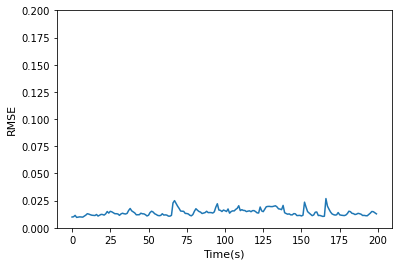

In [28]:
mse_of_two(input_, output_)

十个数据

In [3]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)        #Python
device = 'cuda' if torch.cuda.is_available() else 'cpu'    #cuda
#perm_list=torch.load(dataset_dir+'/perm_list.pt')
perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)

pathE='/root/data1/bubble_EMD/Encode_state_dict.pt'
pathD='/root/data1/bubble_EMD/Decode_state_dict.pt'
pathED = '/root/data1/bubble_EMD/ED_state_dict.pt'
epochs = 200

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset = torch.load(file_path)
print(len(dataset))
#EDstats_list = get_EDstats(dataset)

[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = torch.load(dataset_dir+'/EDstats_list.pt')

(EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge)=(EDmean_vec_x.to(device),
        EDstd_vec_x.to(device),EDmean_vec_edge.to(device),EDstd_vec_edge.to(device))

train_size=7        #改
train_loader = DataLoader(dataset[:train_size],  shuffle=False)
valid_loader = DataLoader(dataset[train_size:], shuffle=False)#分一下训练数据和验证数据


sample = dataset[:train_size][0]

in_channels_node = sample.x.shape[1]  #2
in_channels_edge = sample.edge_attr.shape[1]  #3
hidden_channels = 32    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=32
ae_dim=[300,128,64,32]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[2700,2000,1400]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False

cuda
cuda:0
8


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
model = MessagePassing_Autoencode_attn(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
model.to(device)

model.load_state_dict(torch.load(pathED), strict=False)
dataset = torch.load('/root/data1/bubble_EMD/meshgraphnets_miniset1251traj50350ts_vis.pt')
loader = DataLoader(dataset,  shuffle=False)
print(len(dataset))
per_t=1
batch_size=25     #改
num=int(dataset[0].x.shape[0]/(per_t*batch_size))
print(num)
pred=torch.tensor([[0,0]]).type(torch.float).to(device)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with torch.no_grad():
  for step, data in enumerate(loader):
    data=data.to(device)
    out, _ = model(data, per_t ,perm_list[0], batch_size,EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge,batch=None, return_mask=False)
    pred=torch.vstack((pred,out))
pred=pred[1:,:]
print(pred.shape)   #200*3718
pred=pred*EDstd_vec_x+EDmean_vec_x   #pred是torch，行数为600个时间*点数，列为2
#per_t=1
#batch_size=1
#get_dataset(number_trajectories,number_ts,per_t,batch_size,dataset_dir,path)
file_path_ed='/root/data1/bubble_EMD/meshgraphnets_miniset111traj50450ts_vis.pt'
dataset_input = torch.load(file_path_ed)
print(len(dataset_input)) #200
print(dataset_input[0])
pred=pred.to('cpu')
viz_data = {}
viz_data_loader = copy.deepcopy(dataset_input)

for i in range(int(pred.shape[0]/num)):
  viz_data_loader[i].x=pred[i*num:(i+1)*num,:]
torch.save(viz_data_loader,'/root/data1/bubble_duibishiyan'+'/GA_encode_decode_output'+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')#300个data

14
3351
torch.Size([1172850, 2])
450
Data(x=[3351, 2], edge_index=[2, 19634], edge_attr=[19634, 3], cells=[6467, 3], mesh_pos=[3351, 2])


In [4]:
M_encode=GNN_topk_encode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
M_encode.to(device)
M_encode.load_state_dict(torch.load(pathE), strict=False)


decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)
decode_model.to(device)

AttributeError: 'Global_attention' object has no attribute 'min_score'

In [5]:
per_t=1     
satart_number_ts=50
number_ts=10
batch_size = int(number_ts/per_t)
dataset_dir = '/root/data1/bubble_EMD'
path='/root/data1/water_slice_'     #将文件命名为yuan_0
number_trajectories=1

#get_dataset(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,dataset_dir,path)

file_path= dataset_dir+'/meshgraphnets_miniset'+str(per_t)+str(batch_size)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt'
dataset_M = torch.load(file_path)
print(len(dataset_M))   #长度为1  

perm_list=torch.load(dataset_dir+'/perm_list_150.pt')

print(device)
for i in range(len(perm_list[0])):
   
    perm_list[0][i]=perm_list[0][i].to(device)
print(perm_list[0][0].device)




with torch.no_grad():
  for i in range(len(dataset_M)):
    dataset_M[i]=dataset_M[i].to(device)
    data_list,batches , xs, positions, edge_attrs, edge_indices, edge_masks= M_encode(dataset_M[i], per_t , perm_list[0],
                                                                                            batch_size,EDmean_vec_x,EDstd_vec_x,
                                                                                            EDmean_vec_edge,EDstd_vec_edge,
                                                                                            batch=None, return_mask=False)  
    torch.save(data_list,dataset_dir+'/M_encode_output_'+str(i)+str(number_trajectories)+'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
    torch.save(batches,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
    torch.save(xs,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
    torch.save( positions,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
    torch.save( edge_attrs,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
    torch.save( edge_indices,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
    torch.save( edge_masks,dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')
    
    print(len(data_list))#10
    print(data_list[0],data_list[1],data_list[2],data_list[3],data_list[4],data_list[5])

1
cuda
cuda:0
10
Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32]) Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32])


In [6]:
per_t=1     
batch_size = int(number_ts/per_t)
data_encode=torch.load(dataset_dir+'/M_encode_output_'+str(0)+str(number_trajectories)
                                             +'traj'+str(per_t)+str(batch_size)+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(data_encode)) #10
data=copy.deepcopy(data_encode[0:10])
a=copy.deepcopy(data_encode[0])
print(a)

10
Data(x=[1400, 32], edge_index=[2, 3264], edge_attr=[3264, 32])


In [7]:
edge_num=a.edge_attr.shape[0]
print(edge_num)#9762

3264


In [13]:
predict_num=440 #300
seq_len=10
data=predict_sequences_multiple(node_model, data, a, predict_num,seq_len)
print(len(data))  #60

[Model] Predicting Sequences Multiple...
450


In [14]:
i=0
batches=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'batches.pt')
xs=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'xs.pt')
positions=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'positions.pt')
edge_attrs=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_attrs.pt')
edge_indices=torch.load( dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_indices.pt')
edge_masks=torch.load(dataset_dir+'/'+str(satart_number_ts)+str(i)+str(number_trajectories)+'traj'+'edge_masks.pt')




perm_list=torch.load(dataset_dir+'/perm_list_150.pt')


pred_x=[]
with torch.no_grad():
        for i in range(len(data)):
              x=decode_model(data[i], batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
              x=x*EDstd_vec_x+EDmean_vec_x
              pred_x.append(x)

              
print(len(pred_x))

450


In [15]:
for i in range(number_trajectories):
    satart_number_ts=50
    ts=len(pred_x)
    originalFolder='/root/data1/water_slice_'+str(i)
    destinationFolder='/root/data1/ROM_pred_bubble_dataset_EDoutput_'+str(predict_num)+str(i)
    fileName="/slice_"
    ROM_transform_vector(pred_x, satart_number_ts,ts, originalFolder, destinationFolder, fileName)

start to create the destination folder
start to store data as a new variable
transform succeed


In [16]:
def pcc_of_two(ori_data, rom_data):

    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            pcc_x = pearson_value(y_u, y_0_u)
            pcc_y = pearson_value(y_v, y_0_v)
            plt.figure(1)
            plt.plot(pcc_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(pcc_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            pcc = pearson_value(ori_data, rom_data)
            # print(pcc.shape)
            f=plt.figure(1)
            # x = np.linspace(0,pcc.shape[0], num = pcc.shape[0])
            plt.plot(pcc)
            plt.ylim((0.8, 1))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('Pearson Correlation Coefficient',{'size' : 11})
            plt.show()
            f.savefig('/root/data1/bubble_EMD/pcc_pre_circle_230.pdf', bbox_inches='tight')
    else:
        print('the dimension of these two series are not equal. Please check them.')

In [17]:
def get(number_trajectories,satart_number_ts,number_ts,per_t,batch_size,path):
  data_list = []

  for i in range(number_trajectories):

    if os.path.isdir(path):
      path_k=path
      print(path_k)
      vtk_num=get_vtk_num(path_k)
      print(vtk_num)
      for ts in range(satart_number_ts,vtk_num):
        
        if(ts==number_ts+satart_number_ts):
          break
        point, cells, velocity=read_vtk_file(path_k+"/slice_"+str(ts+i)+".vtk")
        
        data_list.append(Data(x=velocity))
  return data_list

In [22]:
dataset_dir = '/root/data1/bubble_EMD'

number_trajectories=1
satart_number_ts=50
number_ts=310
path='/root/data1/ROM_pred_bubble_dataset_EDoutput_3000'
ED_out=get(number_trajectories,satart_number_ts,number_ts,1,1,path)
print(ED_out)
print(len(ED_out))
ED_out=ED_out[0:310]
path='/root/data1/water_slice_'
#get_dataset(number_trajectories,satart_number_ts,number_ts,1,1,dataset_dir,path)
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:310]

/root/data1/ROM_pred_bubble_dataset_EDoutput_3000
501
[Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 2]), Data(x=[3351, 

(310, 6702) (310, 6702)


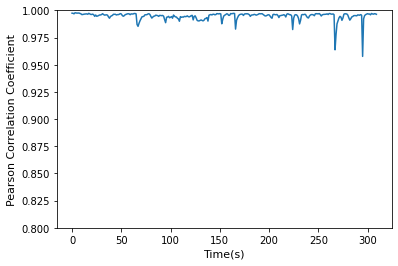

In [23]:

ts=310

for i in range(ts):
    
    uvw=ED_out[i].x.reshape(1,ED_out[i].x.shape[0],ED_out[i].x.shape[1]).to('cpu')
    ouvw=ori[i].x.reshape(1,ori[i].x.shape[0],ori[i].x.shape[1])
    outputs = uvw if i==0 else np.vstack((outputs,uvw))
    inputs=ouvw if i==0 else np.vstack((inputs,ouvw))

output_ = np.hstack((outputs[:,:,0],outputs[:,:,1]))
input_ = np.hstack((inputs[:,:,0],inputs[:,:,1]))
print(output_.shape,input_.shape)

pcc_of_two(input_, output_)

In [59]:
from keras import backend as K
def mse(ori_data, rom_data):

    rmse_value = []
    acc=torch.nn.MSELoss()
    if len(ori_data) != len(rom_data):
        print('the length of these two array do not match')
    else:
        for i in range(len(rom_data)):
            #value = mean_squared_error(ori_data[i], rom_data[i])
            ori=torch.Tensor(ori_data[i])
            
            rom=torch.Tensor(rom_data[i])
            
            #k=((torch.norm(ori, p=1))/len(ori))
            
            #value =acc(ori, rom)
            
            value =math.sqrt(acc(ori, rom))
            #value=math.sqrt(acc(ori,rom))/k
            #value =math.sqrt((acc(ori, rom))/(torch.norm(ori, p=1)))
           
            #value =math.sqrt(acc(ori, rom)/(torch.pow((torch.norm(ori, p=2)),2)/len(ori)))
            if i == 0:
                rmse_value = value
            else:
                rmse_value = np.hstack((rmse_value,value))
        rmse_value = np.reshape(rmse_value,(-1,1))
    return rmse_value

def mse_of_two(ori_data, rom_data):
    # , rom_data_1):
    if ori_data.ndim == rom_data.ndim:
        if rom_data.ndim == 3:
            y_u = ori_data[...,0] # u
            y_v = ori_data[...,1] # v
            y_0_u = rom_data[...,0] # u
            y_0_v = rom_data[...,1] # v
            rmse_x = mse(y_u, y_0_u)
            rmse_y = mse(y_v, y_0_v)
            plt.figure(1)
            plt.plot(rmse_x)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE of x axis',{'size' : 11})
            plt.figure(2)
            plt.plot(rmse_y)
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE of y axis',{'size' : 11})
            plt.show()
        elif rom_data.ndim == 2:
            rmse_value = mse(ori_data, rom_data)
            # rmse_value_1 = rmse(ori_data, rom_data_1)
            # print(pcc.shape[0], pcc.shape[1])
            f=plt.figure(1)
            # x = np.linspace(0,rmse_value.shape[0], rmse_value.shape[0])
            # plt.plot(x, rmse_value, x, rmse_value_1)
            plt.plot(rmse_value)
            plt.ylim((0, 0.3))
            plt.xlabel('Time(s)',{'size' : 11})
            plt.ylabel('RMSE',{'size' : 11})
            # plt.legend(['7', '8'], loc='lower right')   
            plt.show()
            f.savefig('/root/data1/bubble_EMD/RMSE.pdf', bbox_inches='tight')
    else:
        print('the dimension of these two series are not equal. Please check them.')

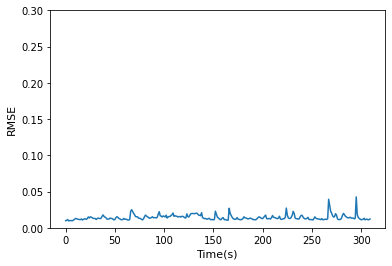

In [60]:
mse_of_two(input_, output_)

In [53]:
def point_over_time(ori_data, edg_data,j,ts , fieldName,path):
        point = [0,ts]
       
        x = np.linspace(point[0],int(point[1]-1),int(point[1]-point[0]))
        y_u=[]
        y_1_u=[]
        for i in range(ts):
            y_u.append(ori_data[i].x[j,0])
            y_1_u.append(edg_data[i].x[j,0])
        print(len(y_u))
        f = plt.figure()
        plt.plot(x, y_u,'k',  linewidth = 0.7)
        plt.plot(x, y_1_u, 'r', linewidth = 0.7)
        plt.xlim((point[0], point[1]))# range
        plt.ylim((-0.2, 0.2))

        #plt.title(' Horizontal liquid velocity (m/s)')
        plt.xlabel('Time(s)')
        plt.ylabel(' Horizontal liquid velocity (m/s)')
        
        plt.legend(['Full Model', 'GNN ROM '], loc='upper right')
        #f.savefig('/root/data1/EMD/'+str(j)+'velocity.pdf', bbox_inches='tight')
        f.savefig(path, bbox_inches='tight')

310
tensor([0.0053, 0.3655])
310


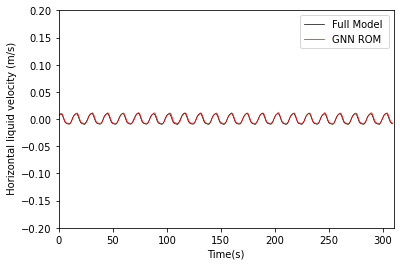

In [54]:
number_trajectories=1
satart_number_ts=50
number_ts=310
ori=torch.load(dataset_dir+'/meshgraphnets_miniset'+str(1)+str(1)+str(number_trajectories)+'traj'+str(satart_number_ts)+str(number_ts)+'ts_vis.pt')
print(len(ori))   #150
ori=ori[0:310]
ts=310
j=2304#3351
fieldName='Velocity'
print(ori[0].mesh_pos[j]) 
path='/root/data1/bubble_EMD/'+str(j)+'velocity.pdf'
point_over_time(ori, ED_out,j,ts , fieldName,path)

In [56]:
j=1904
print(ori[0].mesh_pos[j]) 

tensor([0.1290, 0.1227])


时间计算

In [1]:
import torch
import copy
import time
from GTF import *
from torch_geometric.data import Data
from d_TAP_MP_Attention import *
from bubble_tap_processing import *

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_encode=torch.load('/root/data1/bubble_EMD/M_encode_output_01traj1105010ts_vis.pt')
data=copy.deepcopy(data_encode[0:10])
device ='cpu'    #cuda
for i in range(len(data)):
    data[i].x=data[i].x.to(device)
    data[i].edge_index=data[i].edge_index.to(device)
    data[i].edge_attr=data[i].edge_attr.to(device)
a=copy.deepcopy(data[0])
edge_num=a.edge_attr.shape[0]
print(edge_num)

3264


In [3]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d        
for args in [
        {'model_type': 'meshgraphnet_transformer',
         'num_layers': 2,
         'batchsize': 5,       #是lable上的batchsize
         'hidden_dim': 36,      #在低维空间上的编码可以写大一点，128#30
         'hidden_channels':32,  #这里的hidden_dim与encode_decode中的hidden_channels相同
         'epochs': 2500,#5000
         'attr_epochs':8000,#8000
         'train_size':140, #45
         'test_size': 50, #10         #按照lable的来
         'device':'cuda',
         'shuffle': False,
         'save_best_model': True,
         'checkpoint_dir': '/root/data1/bubble_EMD/mgnn_transformerbest_models/',
         'postprocess_dir': '/root/data1/bubble_EMD/mgnn_transformer_loss_plots/',
         'd_k': 28,#28
         'd_v': 28,
         'input_shape': 12,   #加上时间信息，所以比n_graph_encode的最后一个多两维
         'n_heads': 6,
         'n_layers': 5,
         'ff_dim': 64,
         'seq_len': 10,        #改per_t-1,二推一
         'per_t':11,
         'attr_train_size':270,
         'attr_batchsize':10,
        'n_graph_encode':[500,150,80,10],
        'pool_num':[2700,2000,1400]},
]:
        args = objectview(args)
    
model_name='g_trans_model_nl'+str(args.num_layers)+'_bs'+str(args.batchsize) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd' + \
               '_shuff_'+str(args.shuffle)+'_dk'+str(args.d_k)+'_heads'+str(args.n_heads)
args.batchsize=1
node_model = MeshGraphNet_transformer(args,edge_num)
node_model.load_state_dict(torch.load('/root/data1/bubble_EMD/mgnn_transformerbest_models/'+model_name+'.pt'))

EDstats_list=torch.load('/root/data1/bubble_EMD/EDstats_list.pt')
data_stats_list=torch.load('/root/data1/bubble_EMD/data_stats_list.pt')
[EDmean_vec_x,EDstd_vec_x,EDmean_vec_edge,EDstd_vec_edge] = EDstats_list
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge] = data_stats_list


In [4]:
in_channels_node =2
in_channels_edge =3
hidden_channels = 32    #22#12
out_channels = in_channels_node
batch_size =25       #改
n_mlp_encode = 4
n_mlp_mp = 6#5
encoding_dim=32
ae_dim=[300,128,64,32]#[128,64,32,16,10]
n_mp_down = [2,2,1,1]
n_mp_up= [1,1,2,2]
pool_num =[2700,2000,1400]#[2000,1500,1200,1000][2000,1600,1400,1000]

act = F.elu
param_sharing = False
pathD='/root/data1/bubble_EMD/Decode_state_dict.pt'

In [5]:
decode_model=GNN_Decode(
                hidden_channels,
                in_channels_node,
                in_channels_edge,
                
                out_channels,
                encoding_dim,
                n_mlp_mp,
                n_mlp_encode,

                ae_dim,
                n_mp_down,
                n_mp_up,
                pool_num,
                
                act,
                
                name='gnn_topk')
decode_model.load_state_dict(torch.load(pathD), strict=False)

<All keys matched successfully>

In [6]:
list_p=data
data_loader=DataLoader(list_p, batch_size=10, shuffle=False) 
batches=torch.load('/root/data1/bubble_EMD/5001trajbatches.pt')
for i in range(len(batches)):
    batches[i]=batches[i].to(device)    
xs=torch.load('/root/data1/bubble_EMD/5001trajxs.pt')
for i in range(len(xs)):
    xs[i]=xs[i].to(device) 
positions=torch.load('/root/data1/bubble_EMD/5001trajpositions.pt')
for i in range(len(positions)):
    positions[i]=positions[i].to(device) 
edge_attrs=torch.load( '/root/data1/bubble_EMD/5001trajedge_attrs.pt')
for i in range(len(edge_attrs)):
    edge_attrs[i]=edge_attrs[i].to(device)
edge_indices=torch.load( '/root/data1/bubble_EMD/5001trajedge_indices.pt')
for i in range(len(edge_indices)):
    edge_indices[i]=edge_indices[i].to(device)
edge_masks=torch.load('/root/data1/bubble_EMD/5001trajedge_masks.pt')
for i in range(len(edge_masks)):
    edge_masks[i]=edge_masks[i].to(device)
perm_list=torch.load('/root/data1/bubble_EMD/perm_list_150.pt')

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [528]:
for i,batch in enumerate(data_loader):
    time_start=time.time()
    code_x,code_edge_attr = gmesh_transformer_pred(batch,a,node_model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
    print(time.time() - time_start)
#new_data=Data(x=code_x, edge_index=a.edge_index, edge_attr=code_edge_attr)
#with torch.no_grad():
        #x=decode_model(new_data, batches , xs, positions, edge_attrs, edge_indices, edge_masks,perm_list[0])
        #x=x*EDstd_vec_x+EDmean_vec_x


0.25252199172973633


In [10]:
for i,batch in enumerate(data_loader):
    code_x,code_edge_attr = gmesh_transformer_pred(batch,a,node_model,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)

0.005036115646362305
